In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt

from champ_optics_Model import MCMC_Model,get_mean_err

from glob import glob
from pathlib import PurePath,Path

c:\Users\xiaod\.conda\envs\CCATholo\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
##inputs
Data_folder='./4_30/test_93cm/find_focus/'
keywords='D_93cm_paper*'
outputfolder='./Results/93cm/'

In [3]:
def plot_meas(data_List,data_f_List):
    fig = plt.figure(figsize=(12,10))
    for idx, data in enumerate(data_List):
        x = data[:,0]
        plt.subplot(211)
        plt.plot(
            x,
            data[:,1],
            '*-',
            label=f"{data_f_List[idx].split('/')[-1]}"
        )
        plt.legend(fontsize=5)
        plt.xlabel(r'$\Delta z$ [mm]')

        plt.subplot(212)
        freq = fft.fftshift(
            fft.fftfreq(
                data.shape[0],
                np.diff(x).mean()
            )
        )
        delta_x = np.diff(x).mean()
        spectrum = fft.fftshift(fft.fft(data[:,1])) / (freq.size)
        plt.plot(
            1./freq,
            np.abs(spectrum),'*-',
            label=f"{data_f_List[idx].split('/')[-1]}"
        )
        plt.xscale('log')
        plt.yscale('log')
        plt.legend(fontsize=12)
        
        plt.xlabel(r'$\lambda \ [\mathrm{mm}]$')
    plt.subplot(211)
    plt.grid(which='both', axis='both')
    plt.subplot(212)
    plt.grid(which='both', axis='both')
    plt.tight_layout()

def get_samples(data_List):
    data_samples=np.zeros([data_List[0].shape[0],len(data_List)])
    for idx, data in enumerate(data_List):
        data_samples[:,idx] = data[:,1]
    x_vec=data_List[0][:,0]

    data_samples_zp = data_samples.copy()
    freq_vec = fft.fftshift(
        fft.fftfreq(
            data_samples_zp.shape[0], 
            np.diff(x_vec).mean()
            )
        )
    spec_samp = fft.fftshift(
        fft.fft(data_samples_zp, axis=0) / (len(freq_vec) // 2)
        )
    
    return x_vec, data_samples, freq_vec, spec_samp
    
def plot_correct(x_vec,samples,f_vec,spec):
    fig = plt.figure(figsize=(12,10))
    plt.subplot(311)
    samples=samples-samples.mean(axis=0)
    mean,err = get_mean_err(samples)
    spec_mean,spec_err = get_mean_err(np.abs(spec))
    plt.errorbar(
        x_vec,
        mean,
        yerr=err,
        marker='.', ls='--', color=f'gray',
        label=f"all data",
        capsize=3, markeredgewidth=2,
        fillstyle='none'
    )
    plt.grid(which='both', axis='both')
    plt.legend()
    plt.xlabel(r'$\Delta z$ [mm]')

    plt.subplot(312)
    plt.errorbar(
        1./f_vec,
        spec_mean,
        yerr=spec_err,
        marker='.', ls='--', color=f'gray',
        label=f"all data",
        capsize=3, markeredgewidth=2,
        fillstyle='none'
    )
    plt.xscale('log')
    plt.yscale('log')

    plt.grid(which='both', axis='both')
    plt.legend()
    plt.xlabel(r'$\lambda \ [\mathrm{mm}]$')

    plt.subplot(313)
    plt.errorbar(
        f_vec,
        spec_mean,
        yerr=spec_err,
        marker='.', ls='--', color=f'gray',
        label=f"all data",
        capsize=3, markeredgewidth=2,
        fillstyle='none'
    )
    # plt.xscale('log')
    plt.yscale('log')

    plt.grid(which='both', axis='both')
    plt.legend()
    plt.xlabel(r'$k \ [\mathrm{mm}^{-1}]$')
    plt.tight_layout()
    

### 1. Analysis 93cm separation distance

C:\Users\xiaod\AppData\Local\Temp\ipykernel_12656\2704952921.py:25: RuntimeWarning: divide by zero encountered in divide
  1./freq,
C:\Users\xiaod\AppData\Local\Temp\ipykernel_12656\2704952921.py:80: RuntimeWarning: divide by zero encountered in divide
  1./f_vec,


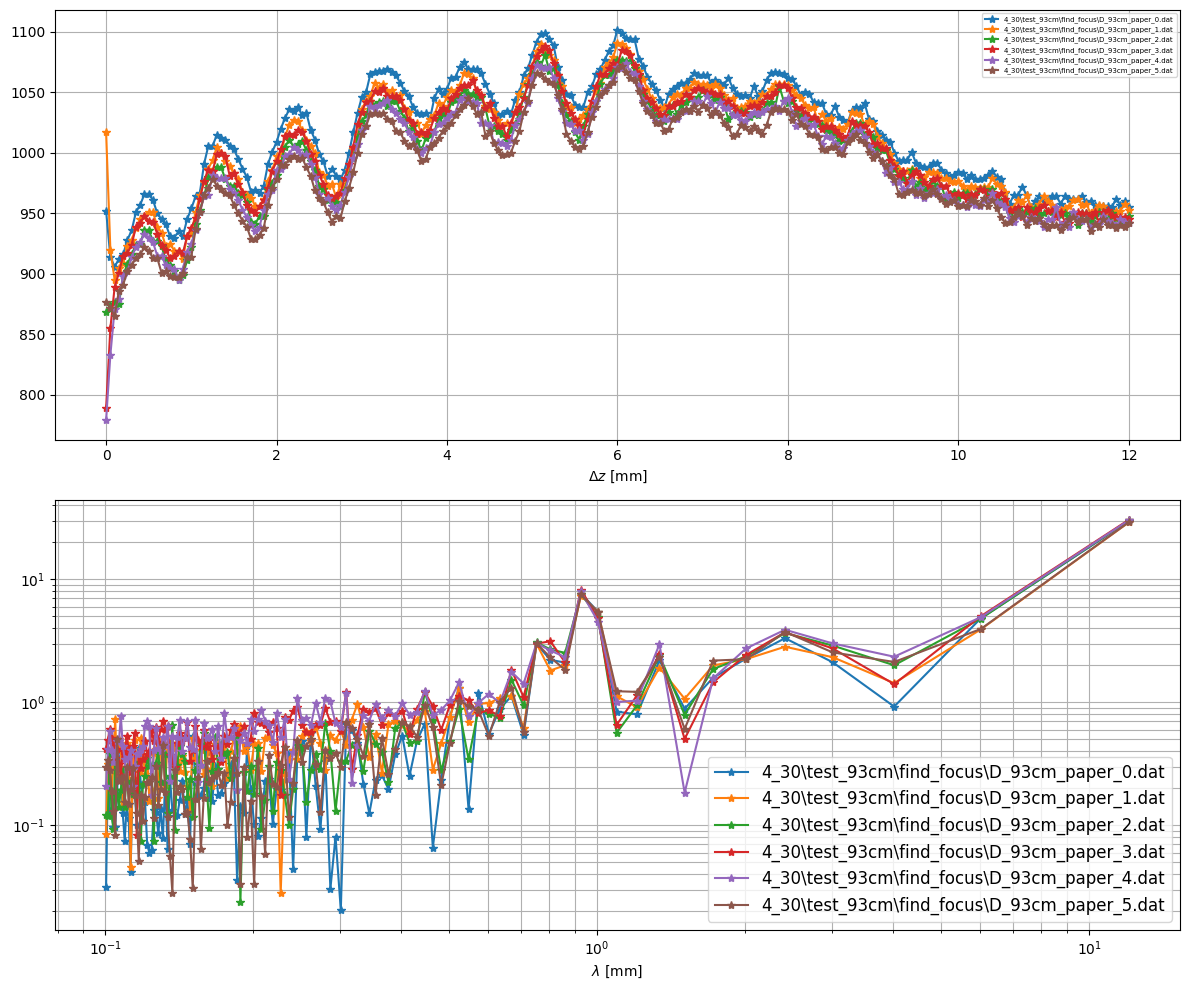

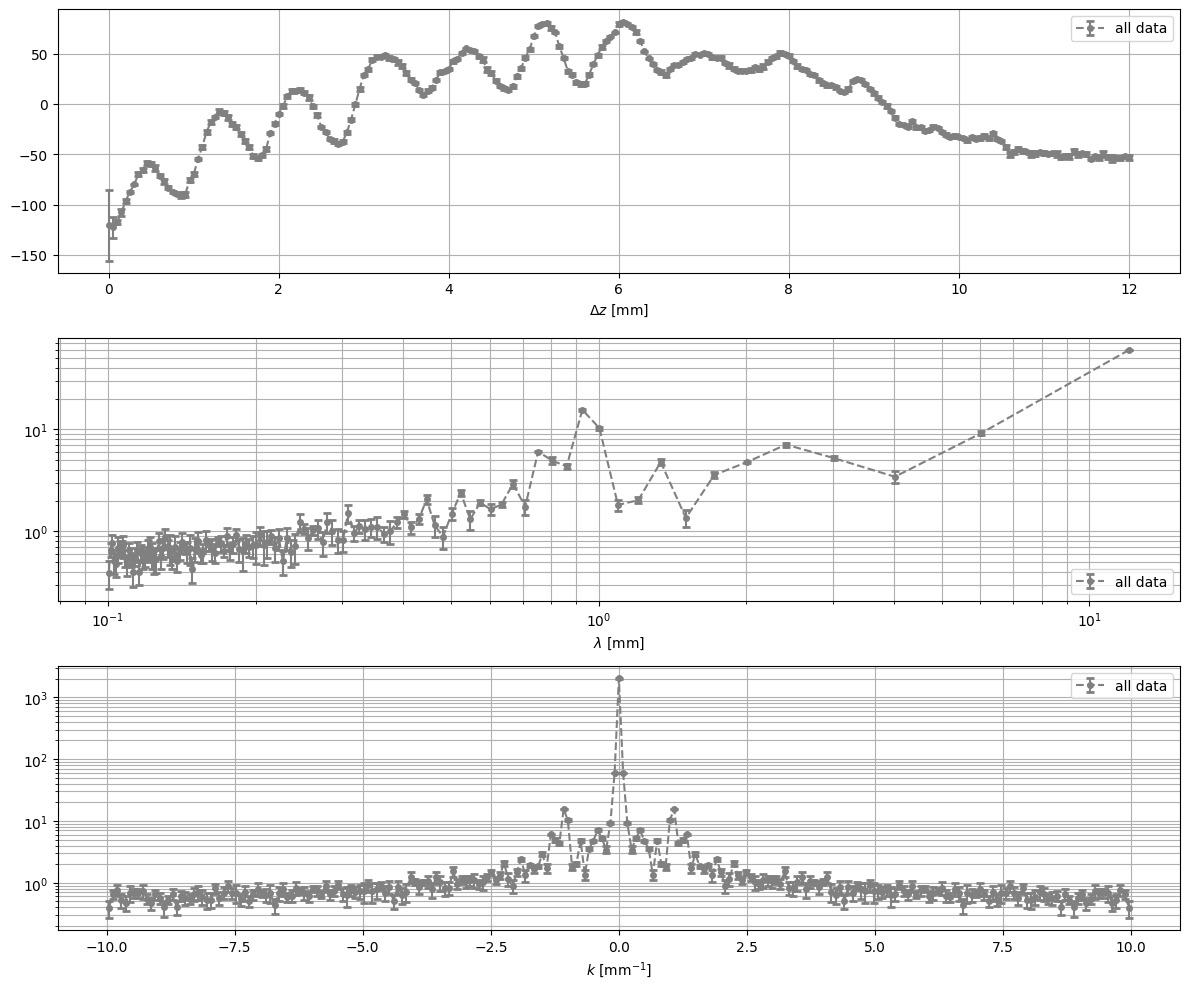

In [4]:
# 1. read data
D_folder=PurePath(Data_folder)
data_file_list = sorted(glob(str(D_folder / keywords)))
data_list1 = [
    np.genfromtxt(data_file) for data_file in data_file_list
]

# 2. plot and analysis its spectrum
plot_meas(data_list1,data_file_list)
z_vec, data_samples1, freq_vec, Spec_samples1 = get_samples(data_list1)
plot_correct(z_vec, data_samples1, freq_vec, Spec_samples1)



#### 3. Run McMc
**3.1. parabolic model

In [5]:
# 3. ran mcmc
# 1. parabolic model
n_walkers = 50

"""Model 1 2nd polynomial model"""
bounds_0 = np.asarray(
    [
        [-8, 0],
        [2, 10],
        [0,100]
    ]
)
Model_2nd = MCMC_Model(
    z_vec, data_samples1, 
    2, 0, 
    bounds_0,
    "2nd poly"
)

corr_time = Model_2nd.sample(
    np.array([-0.005,5,1]),
    n_walkers,
    5000,
    filename=outputfolder+'parab_mcmc_analy.h5'
)


  0%|          | 0/5000 [00:00<?, ?it/s]c:\Users\xiaod\.conda\envs\CCATholo\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:49<00:00, 101.15it/s]


(8800, 3)


e:\E_Laptop_new\Project in Köln\1_Holography inference\CCAT-Documents\HOLO-Ref Rx\optics for CHAI\Fore-optics_Test\champ_optics_Model.py:263: RuntimeWarning: divide by zero encountered in divide
  1./freq,


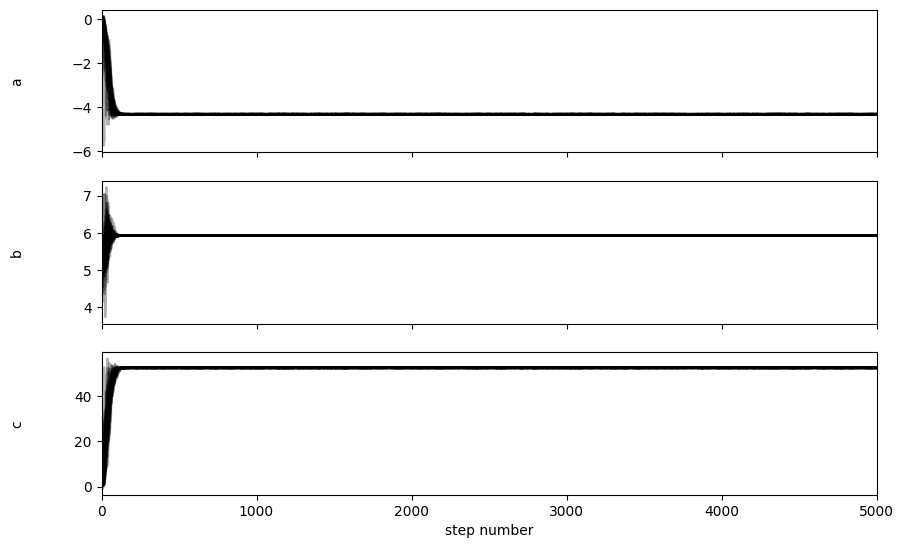

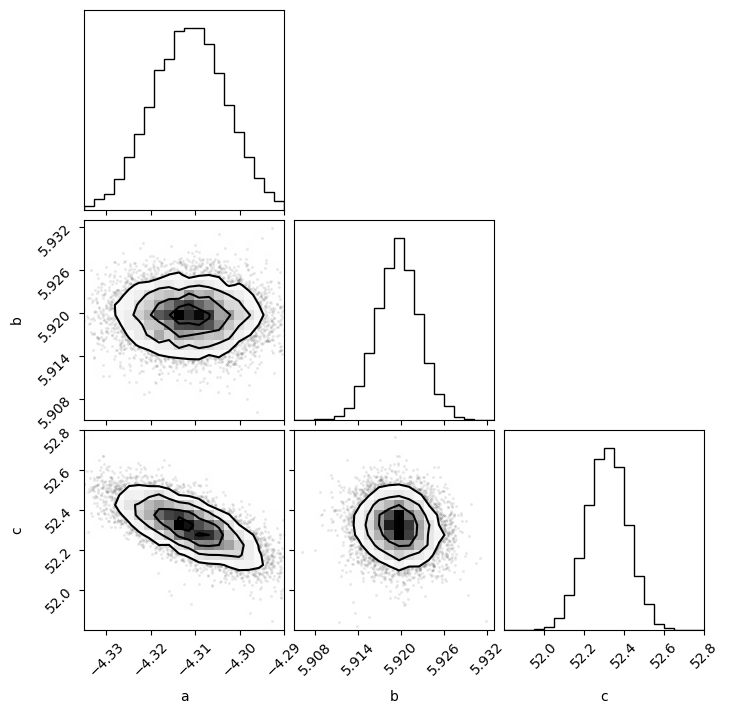

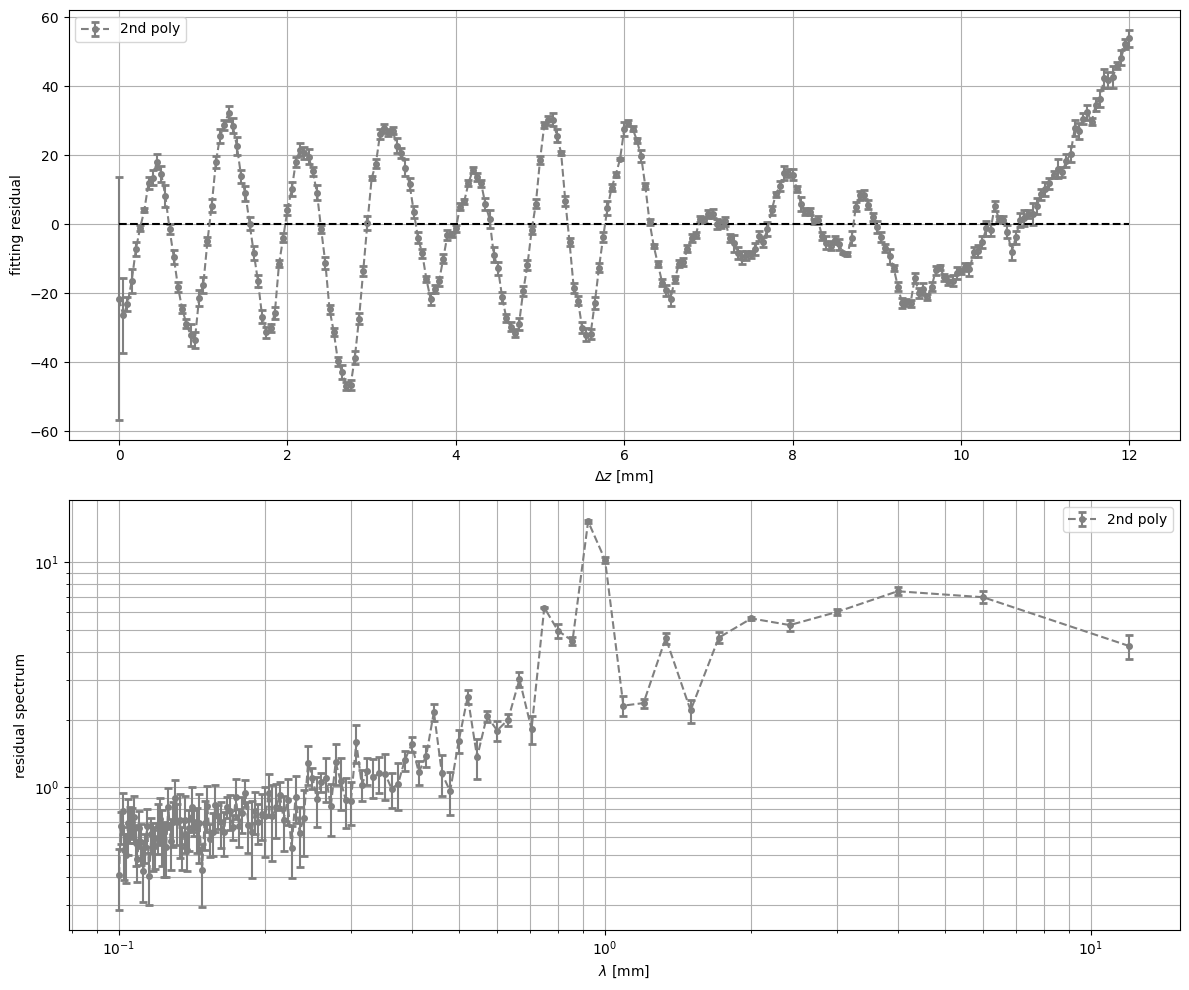

In [6]:
_ = Model_2nd.plot_chain()
_ = Model_2nd.plot_corner(
    discard=2*int(corr_time.max()//2),
    thin=int(corr_time.max()//2),
    range=[
        [-4.335,-4.29],
        [5.905, 5.933],
        [51.8,52.8]
    ]
)
_ = Model_2nd.plot_residual()

In [19]:
"""Model 1 2nd polynomial model + 1sw"""
n_walkers = 50
bounds_0 = np.asarray(
    [
        [-8,-1],
        [2, 8],
        [45,60],
        [5,20],
        [0.9,0.9999999],
        [-np.pi,np.pi]
    ]
)
Model_2nd_1sw = MCMC_Model(
    z_vec, data_samples1, 
    2, 1, 
    bounds_0,
    "2nd poly + 1sw"
)

corr_time = Model_2nd_1sw.sample(
    np.array([-4.25,6.0,50,10,0.975,1]),
    n_walkers,
    20000,
    filename=outputfolder+'parab_1sw_mcmc_analy.h5'
)
print(corr_time)



100%|██████████| 20000/20000 [03:15<00:00, 102.14it/s]


[176.71259321  96.90947378 181.43969842 130.03647297 126.75096453
 106.10496978]


(10900, 6)


e:\E_Laptop_new\Project in Köln\1_Holography inference\CCAT-Documents\HOLO-Ref Rx\optics for CHAI\Fore-optics_Test\champ_optics_Model.py:271: RuntimeWarning: divide by zero encountered in divide
  1./freq,


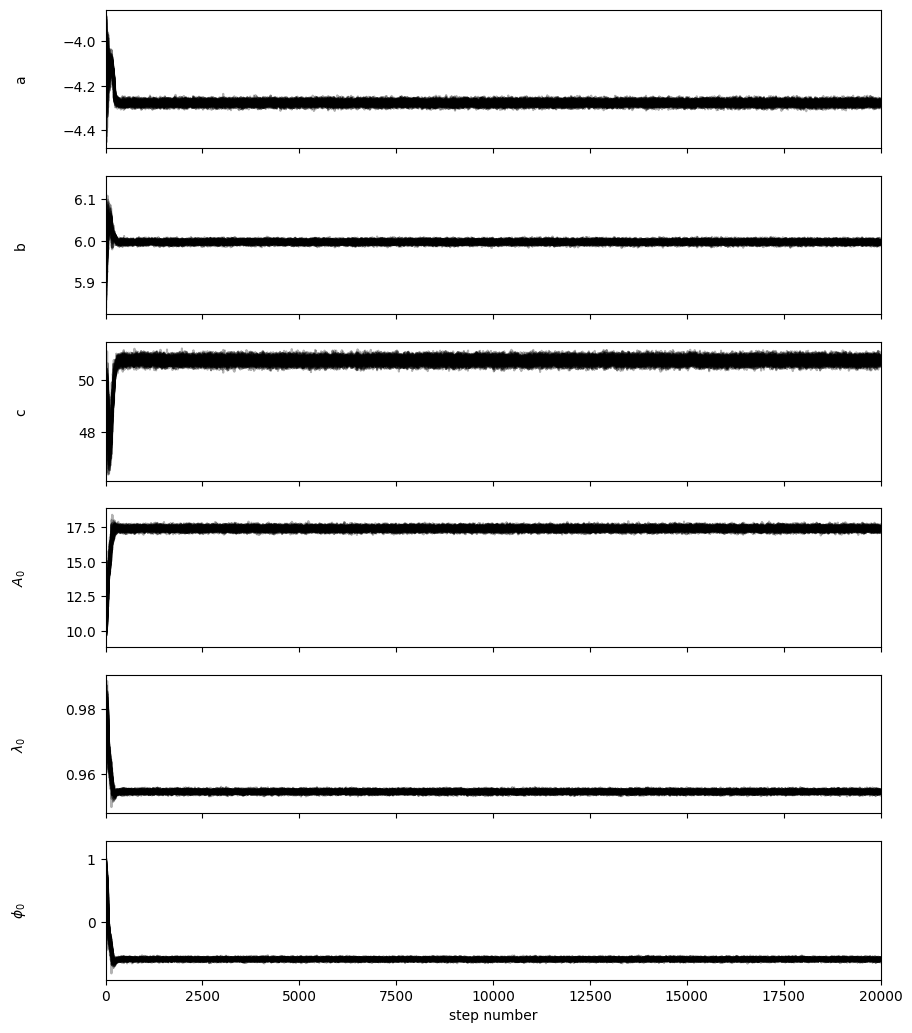

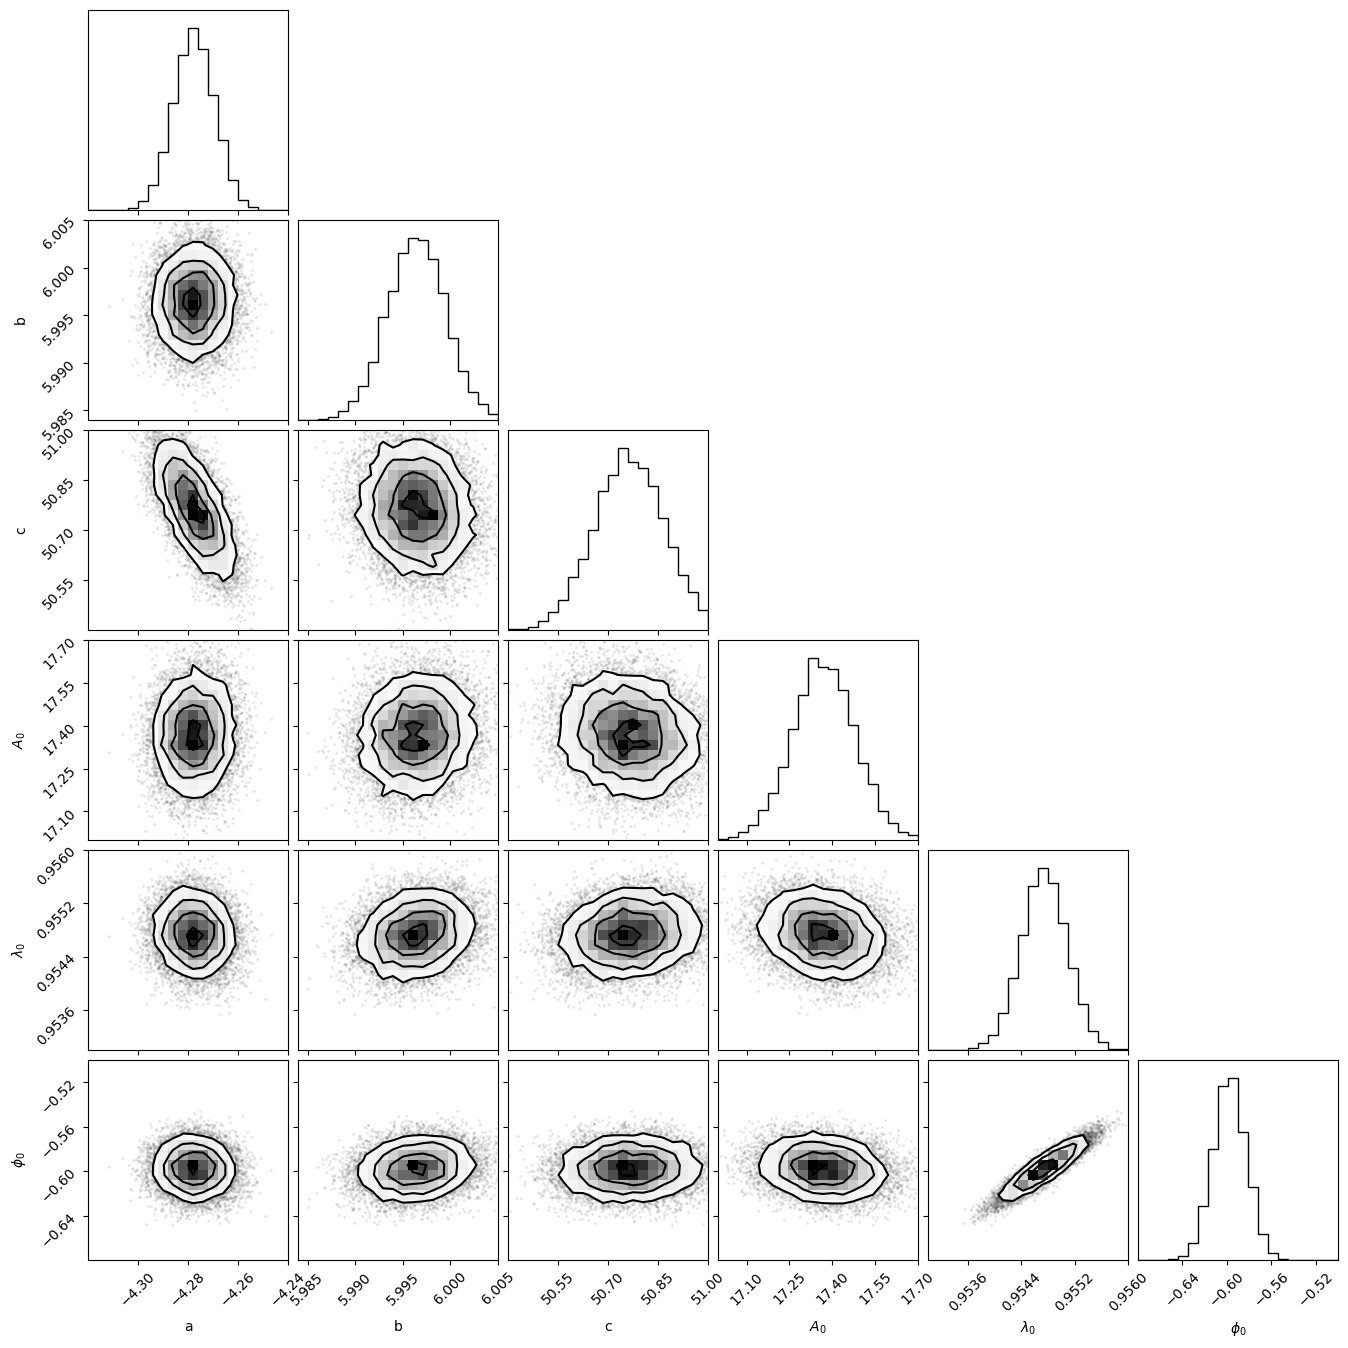

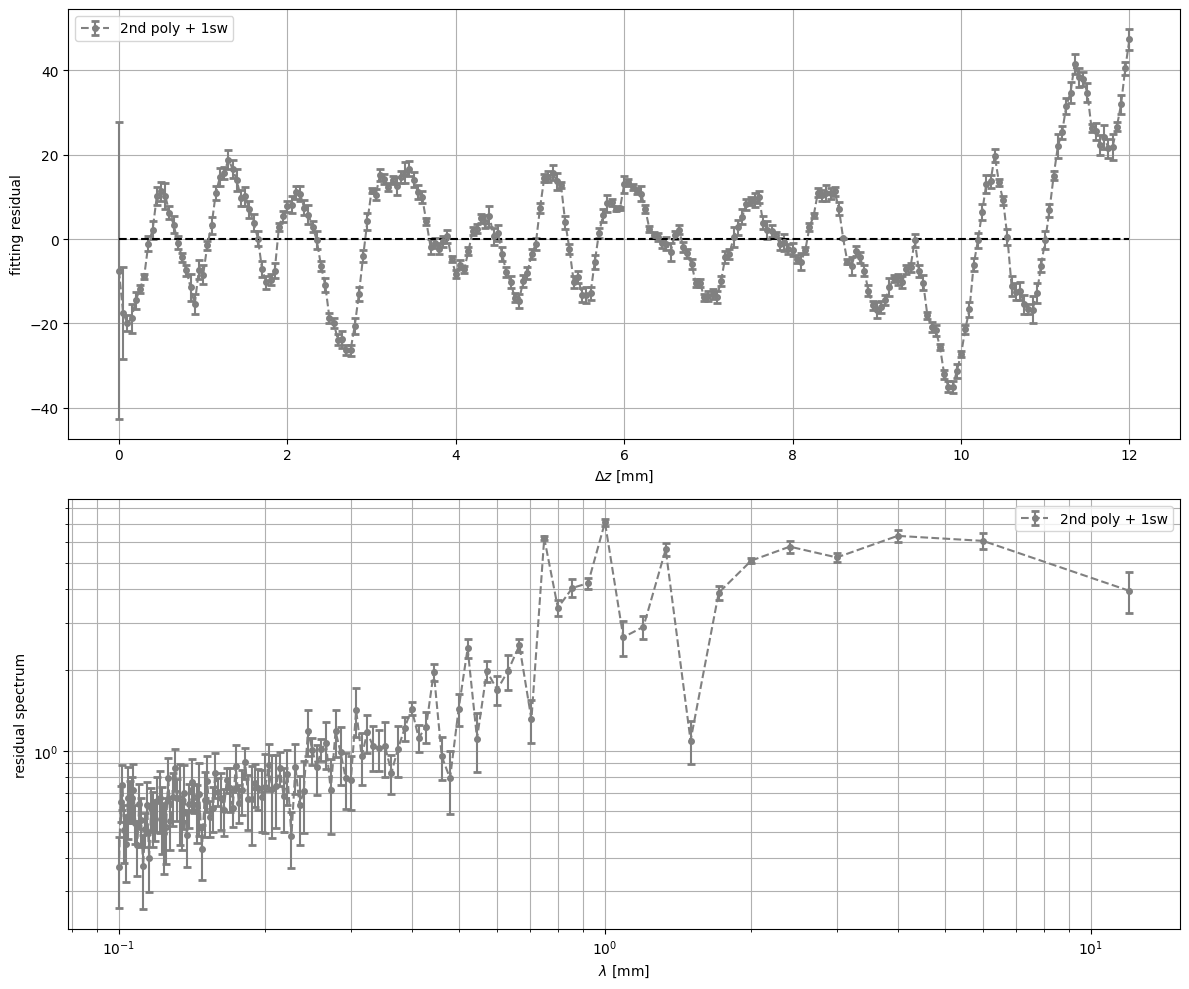

In [20]:
_ = Model_2nd_1sw.plot_chain()
_ = Model_2nd_1sw.plot_corner(
    discard = 2*int(corr_time.max()),
    thin = int(corr_time.max()//2),
    range = [
        [-4.32,-4.24],
        [5.984,6.005],
        [50.4,51],
        [17,17.7],
        [0.953,0.956],
        [-0.68,-0.5]
        ]
)
_ = Model_2nd_1sw.plot_residual()


In [52]:
"""Model 1 2nd polynomial model + 2sw"""
bounds_0 = np.asarray(
    [
        [-8,-1],
        [2, 8],
        [45,60],
        [10,20],
        [0.95,0.96],
        [-0.68,-0.5],
        [1,10],
        [0.9,1.1],
        [-np.pi,np.pi],
    ]
)
Model_2nd_2sw = MCMC_Model(
    z_vec, data_samples1, 
    2, 2, 
    bounds_0,
    "2nd poly + 2sw"
)

corr_time = Model_2nd_2sw.sample(
    np.array([-4.25,6.0,50,15,0.955,-0.6,7,1,1]),
    n_walkers,
    20000,
    filename=outputfolder+'parab_2sw_mcmc_analy.h5'
)
print(corr_time)


100%|██████████| 20000/20000 [03:46<00:00, 88.35it/s]


[104.8861982  106.17402766 107.0480867  119.37449319 236.51203403
 238.45052014 156.01439182  99.41961553 137.98137755]


(8200, 9)


e:\E_Laptop_new\Project in Köln\1_Holography inference\CCAT-Documents\HOLO-Ref Rx\optics for CHAI\Fore-optics_Test\champ_optics_Model.py:271: RuntimeWarning: divide by zero encountered in divide
  1./freq,


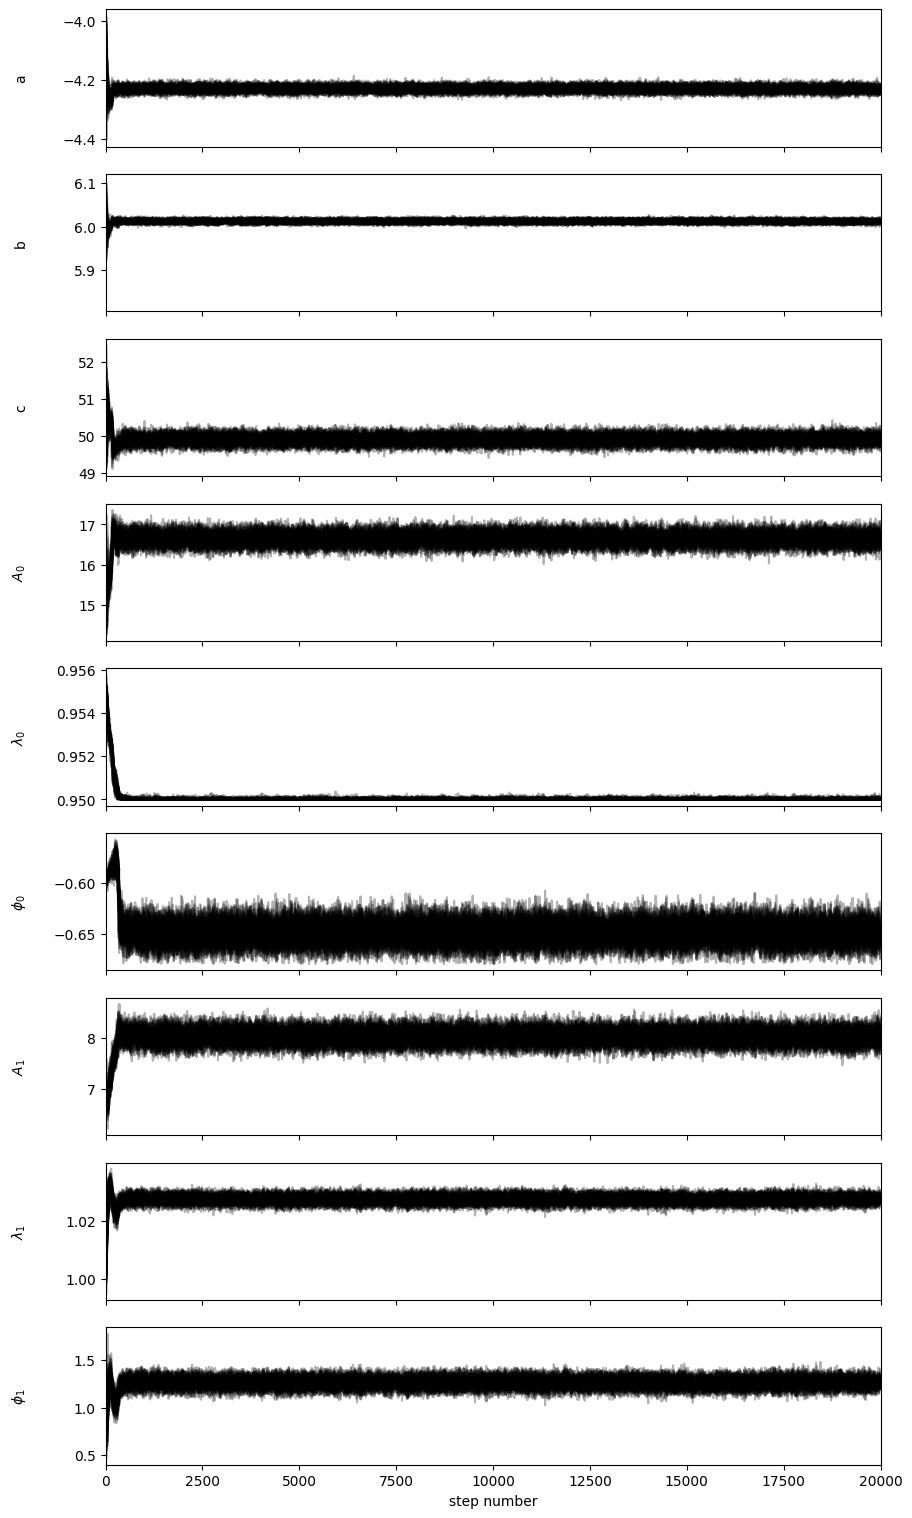

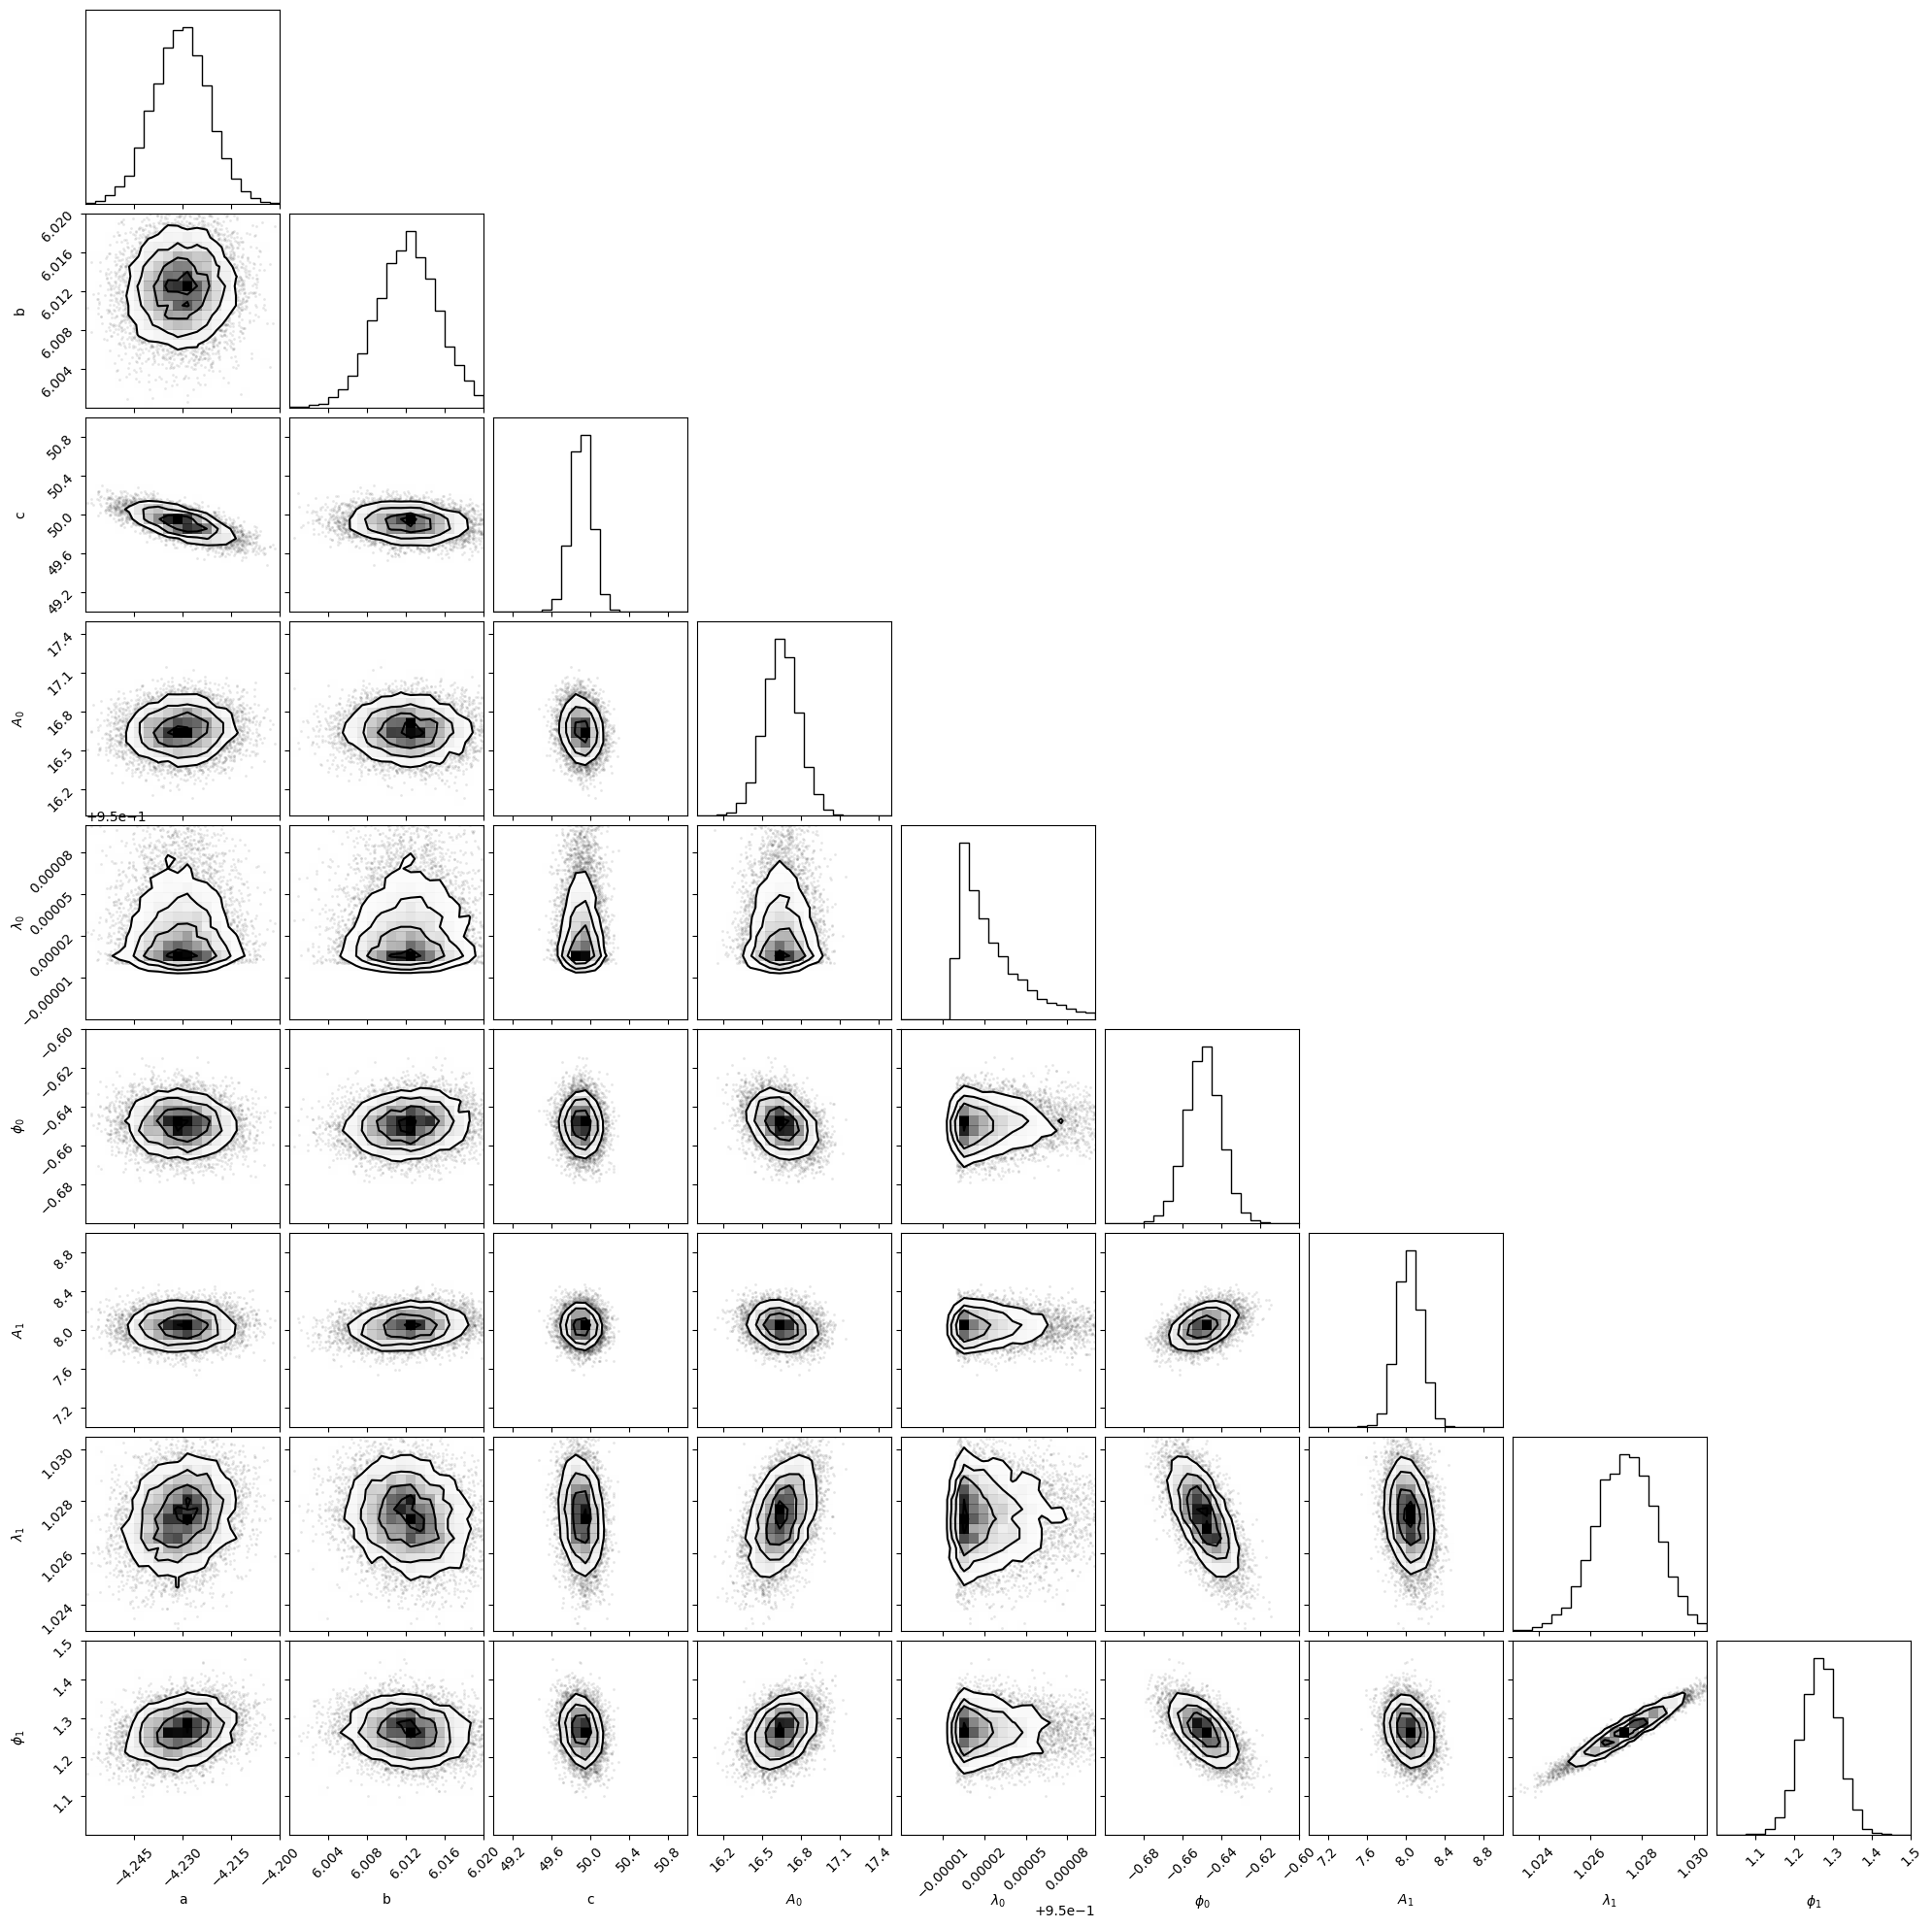

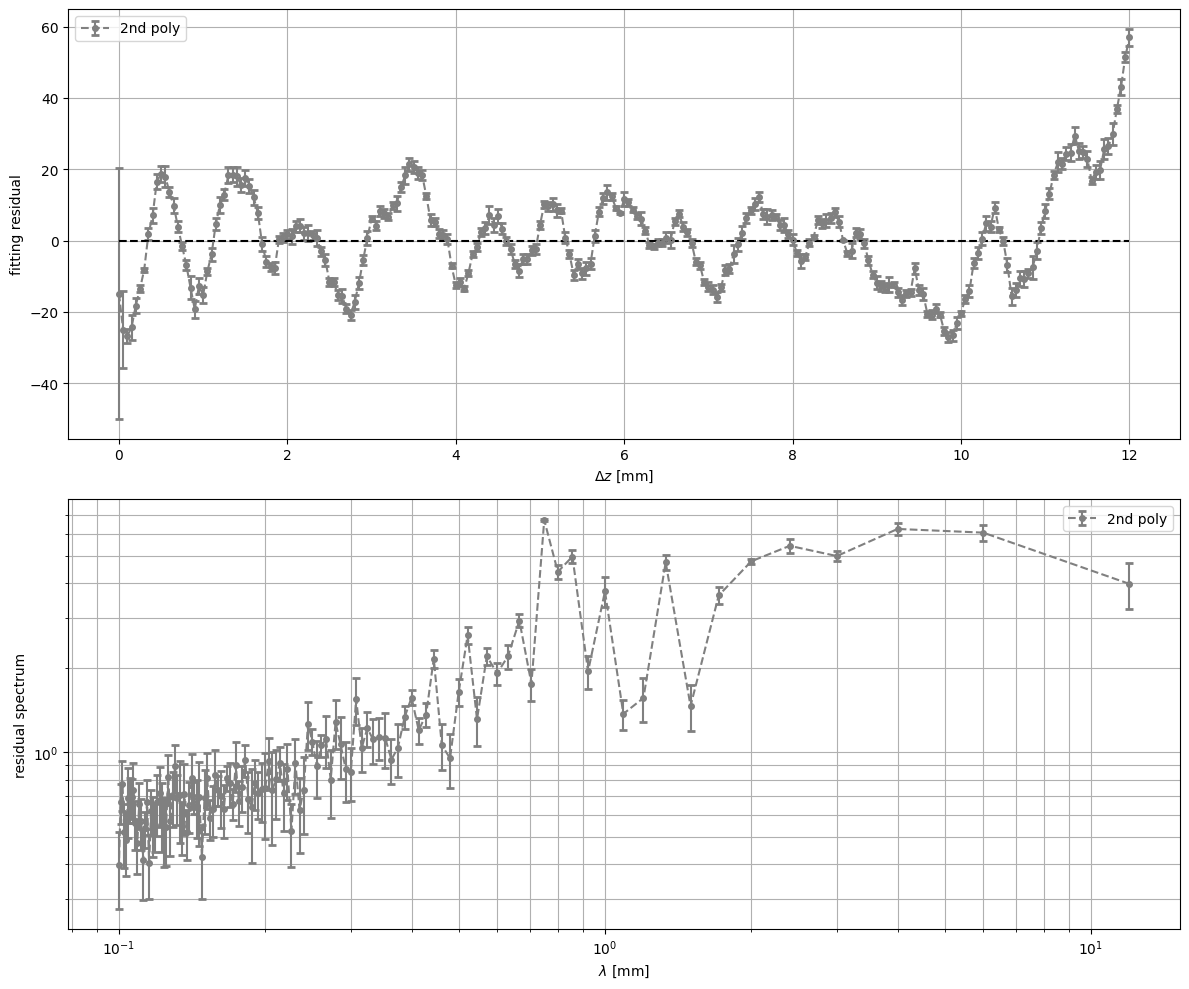

In [68]:
_ = Model_2nd_2sw.plot_chain()
_ = Model_2nd_2sw.plot_corner(
    discard=int(corr_time.max())*2,
    thin=int(corr_time.max()//2),
    range = [
        [-4.26,-4.20],
        [6.0,6.02],
        [49,51],
        [16,17.5],
        [0.94996,0.9501],
        [-0.7,-0.6],
        [7,9],
        [1.0230,1.0305],
        [1.0,1.5]
        ]
)

_ = Model_2nd_2sw.plot_residual()

In [73]:
"""Model 1 2nd polynomial model + 3sw"""
bounds_0 = np.asarray(
    [
        [-8,-1],
        [2, 8],
        [45,60],
        [10,20],
        [0.95,0.96],
        [-0.68,-0.5],
        [1,10],
        [0.9,1.1],
        [-np.pi,np.pi],
        [1,10],
        [0.7,0.8],
        [-np.pi,np.pi]
    ]
)
Model_2nd_3sw = MCMC_Model(
    z_vec, data_samples1, 
    2, 3, 
    bounds_0,
    "2nd poly + 3sw"
)
corr_time = Model_2nd_3sw.sample(
    np.array([-4.25,6.0,50,
              15,0.955,-0.6,
              7,1,1,
              6,0.75,1]),
    n_walkers,
    40000,
    filename=outputfolder+'parab_3sw_mcmc_analy.h5'
)

100%|██████████| 40000/40000 [07:55<00:00, 84.04it/s]


(5850, 12)


e:\E_Laptop_new\Project in Köln\1_Holography inference\CCAT-Documents\HOLO-Ref Rx\optics for CHAI\Fore-optics_Test\champ_optics_Model.py:271: RuntimeWarning: divide by zero encountered in divide
  1./freq,


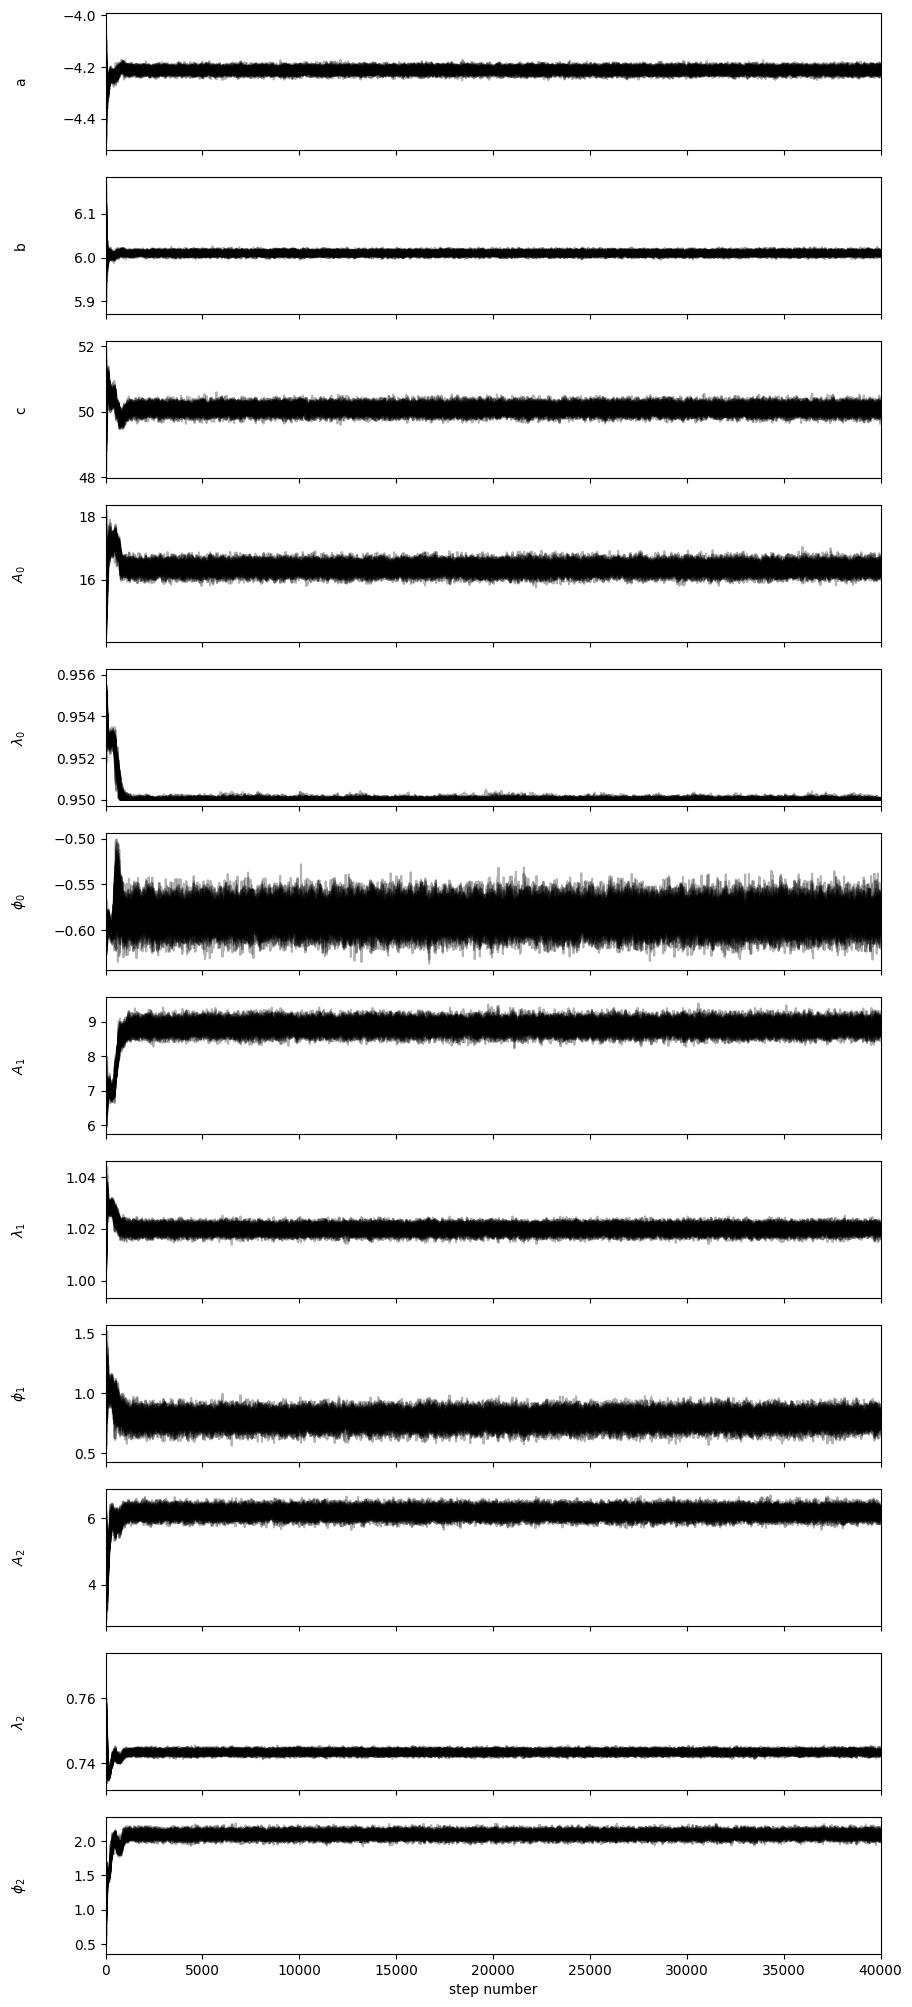

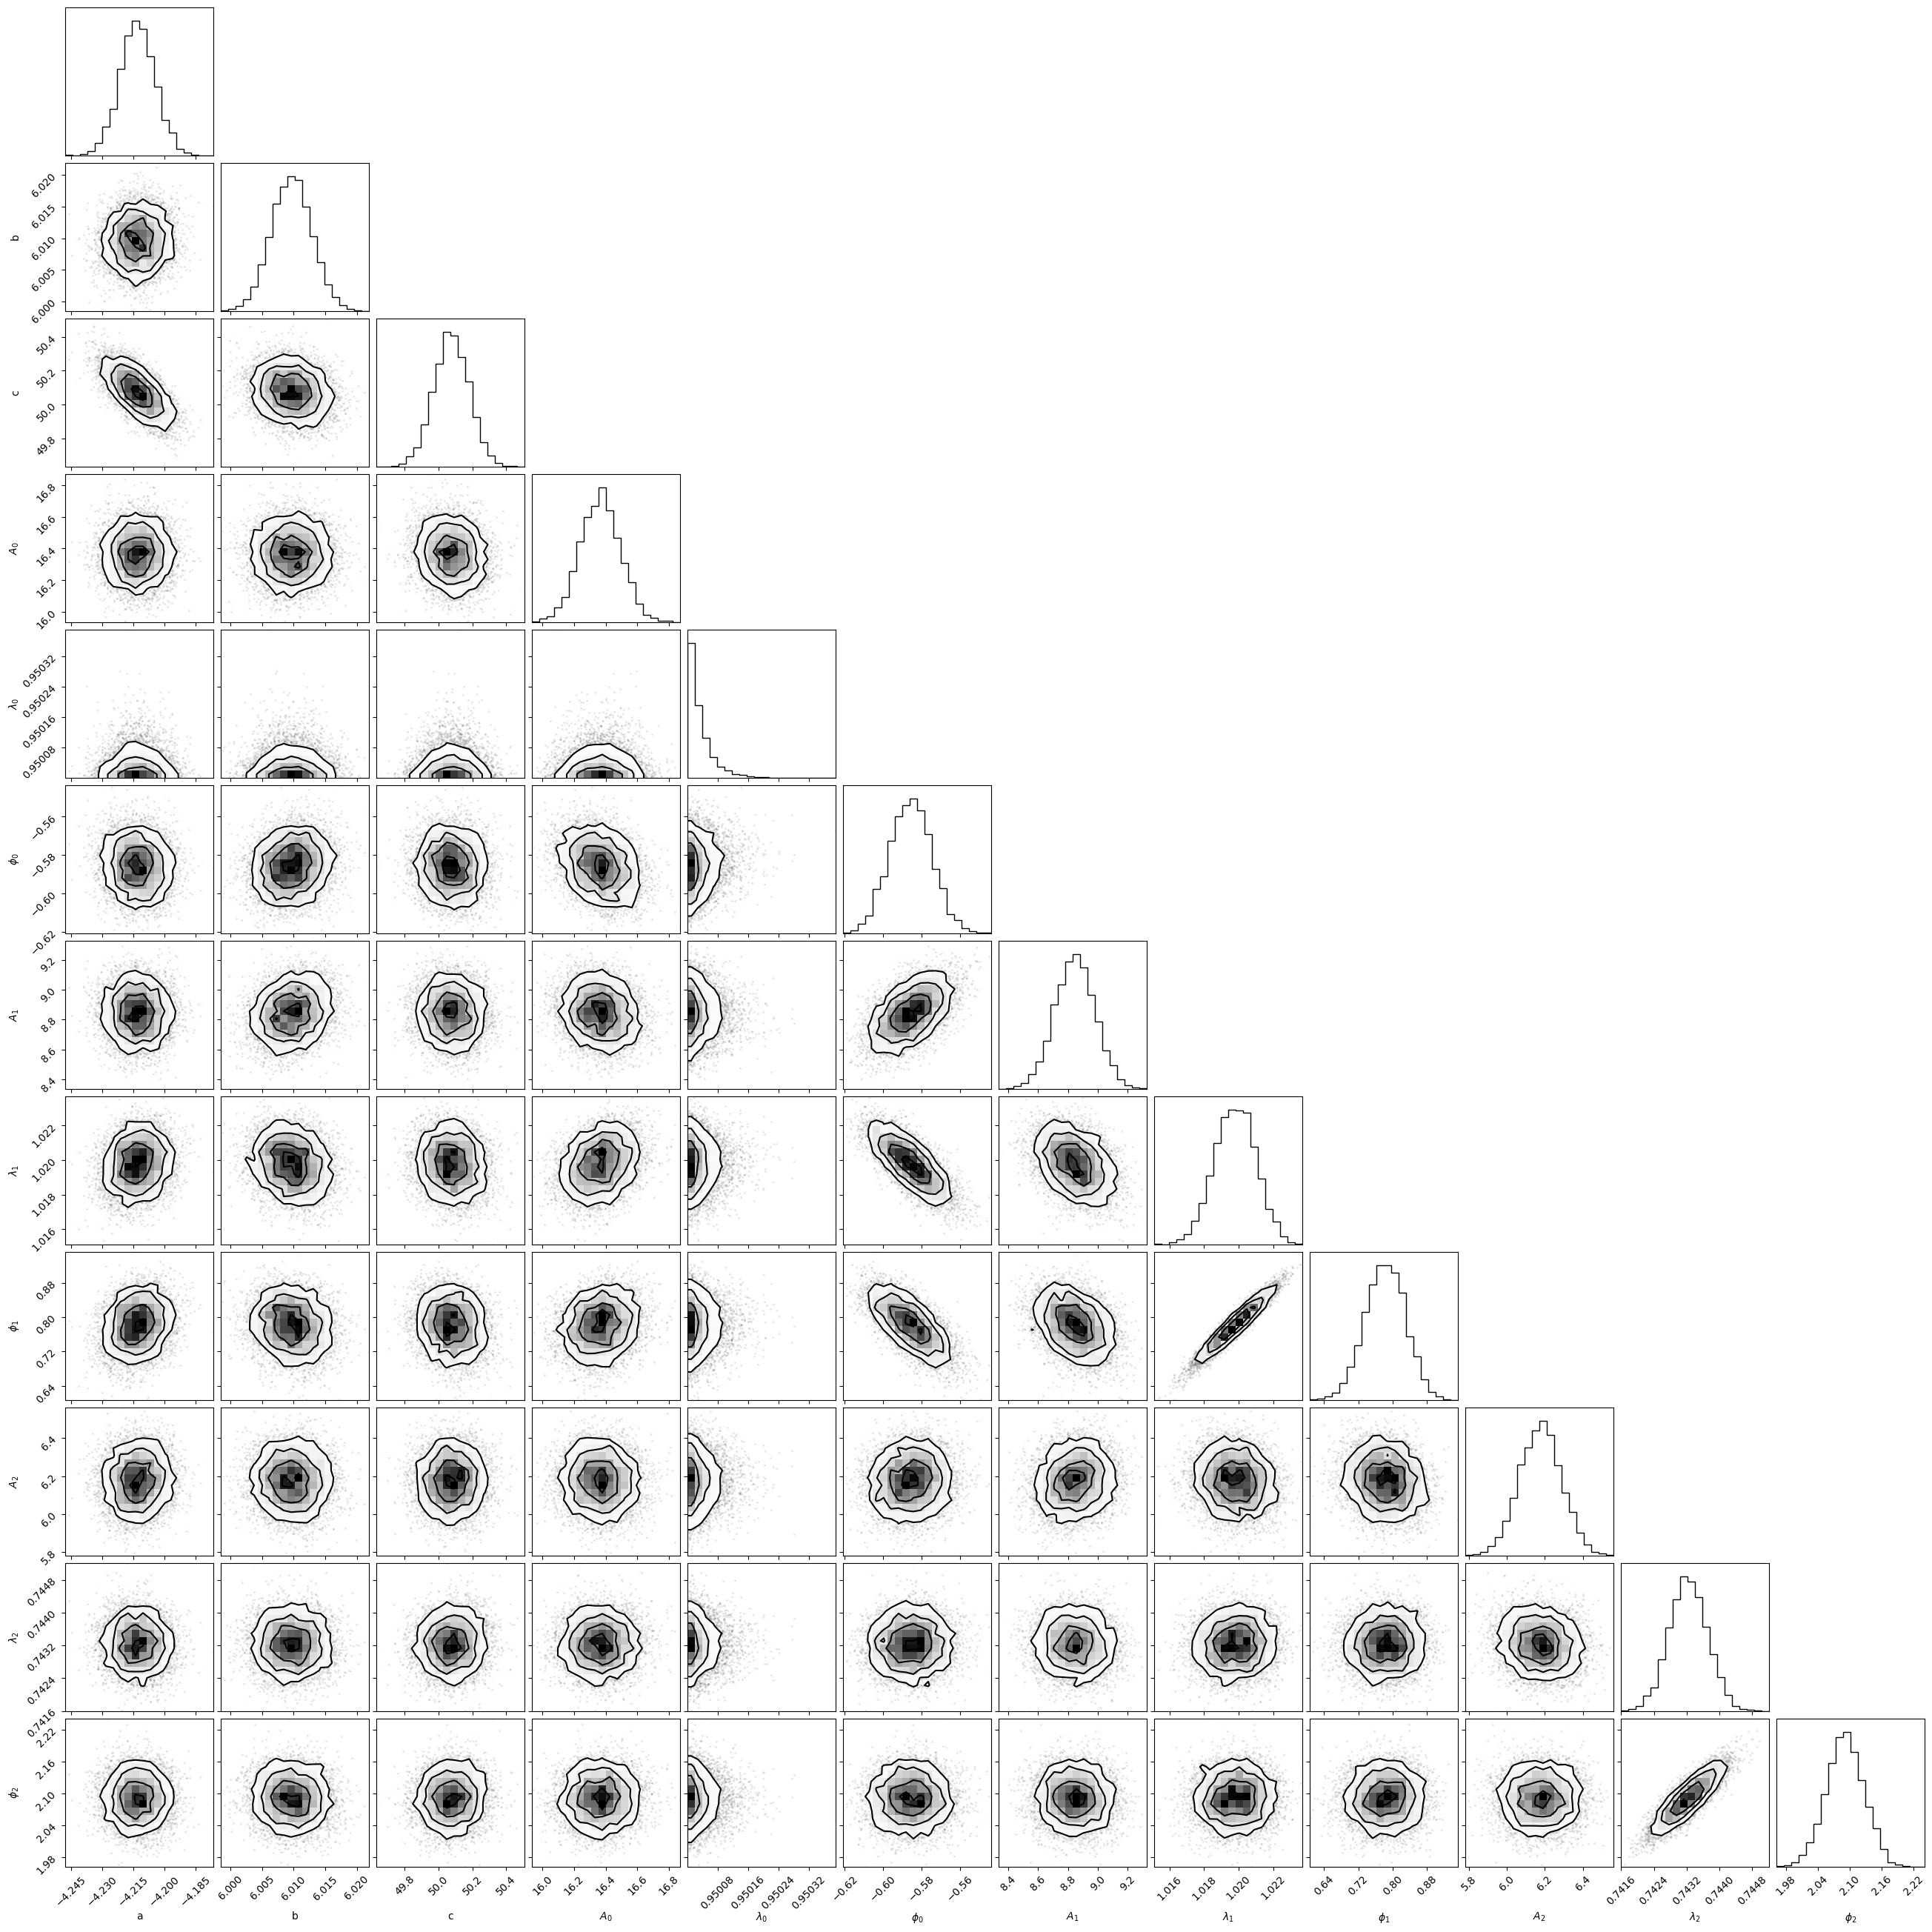

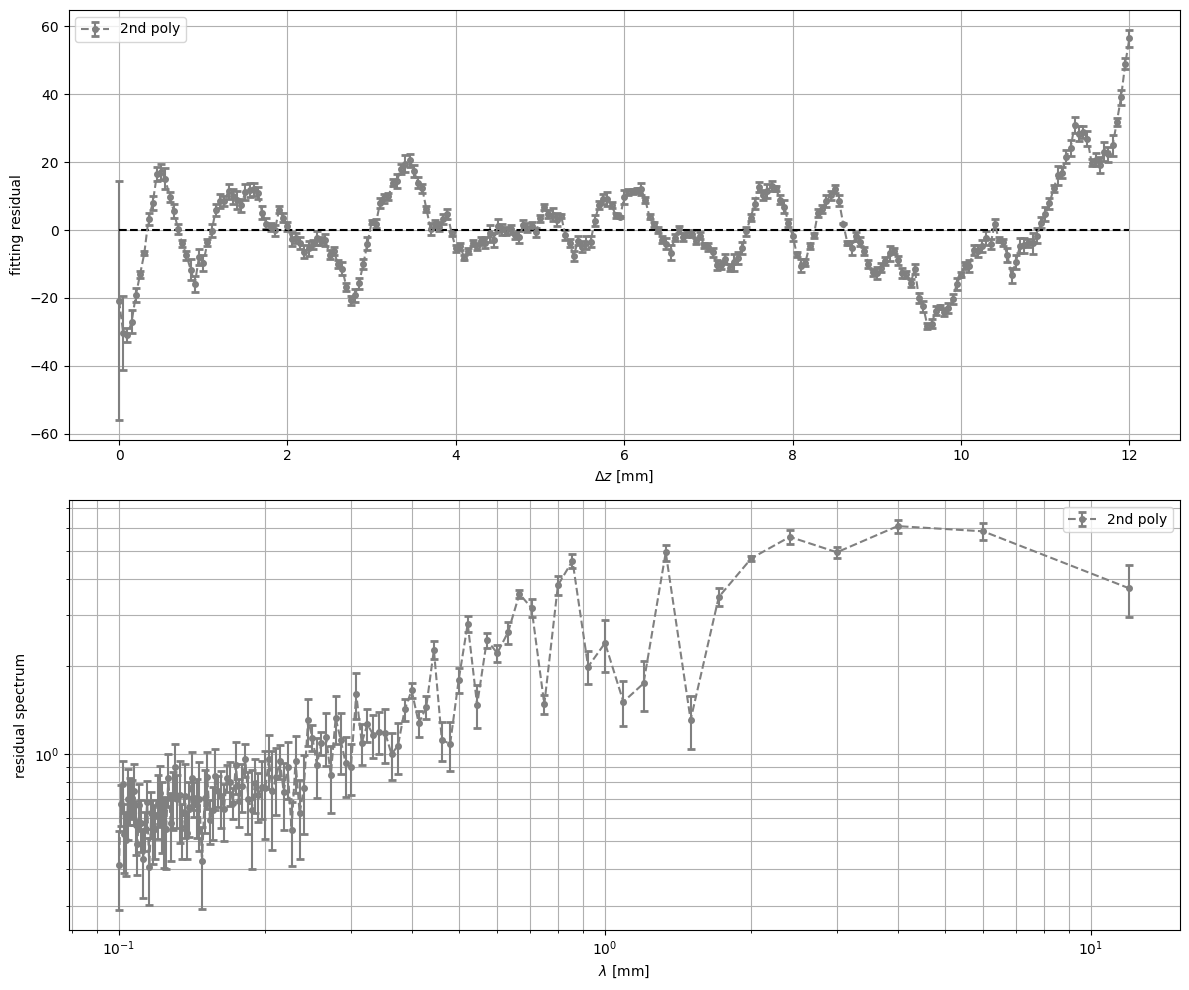

In [74]:
_ = Model_2nd_3sw.plot_chain()
_ = Model_2nd_3sw.plot_corner(
    discard=int(corr_time.max())*2,
    thin=int(corr_time.max()//2),
)
_ = Model_2nd_3sw.plot_residual()

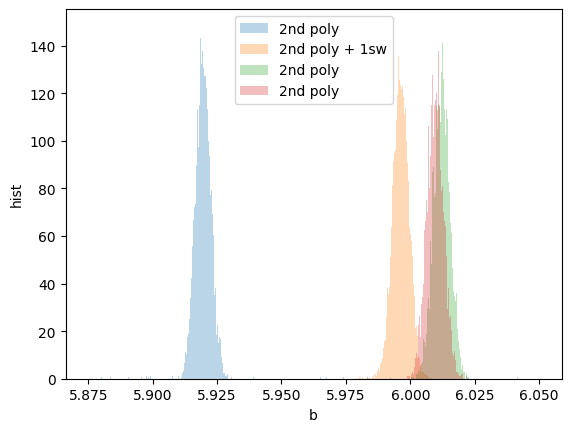

In [80]:
# collect model to list
fit_model_list = [
    Model_2nd,
    Model_2nd_1sw,
    Model_2nd_2sw,
    Model_2nd_3sw,
]

b_bins = np.linspace(5.875, 6.05, 1000)
for idx, fit_model in enumerate(fit_model_list):
    _ = plt.hist(
        fit_model.flat_samples[:,1], bins=b_bins,
        density=True,
        alpha=0.3, color=f'C{idx}',
        label=fit_model.model_label
    )
plt.xlabel("b")
plt.ylabel("hist")
plt.legend()
plt.show()


#### 3. Run McMc
**3.2. sine model

In [96]:
# 3. ran mcmc
# 3.2. sine model
n_walkers = 50

"""Model 1 3rd polynomial model"""
bounds_0 = np.asarray(
    [
        [-100,200],
        [20, 80],
        [10, 30],
        [-np.pi,np.pi],
        
    ]
)
Model_sin = MCMC_Model(
    z_vec, data_samples1, 
    'sin', 1, 
    bounds_0,
    "sin"
)

corr_time = Model_sin.sample(
    np.array([0.0,
              40,
              15,
              0]),
    n_walkers,
    20000,
    filename=outputfolder+'Sine_mcmc_analy.h5'
)

100%|██████████| 20000/20000 [03:28<00:00, 96.10it/s] 


(18650, 4)


e:\E_Laptop_new\Project in Köln\1_Holography inference\CCAT-Documents\HOLO-Ref Rx\optics for CHAI\Fore-optics_Test\champ_optics_Model.py:271: RuntimeWarning: divide by zero encountered in divide
  1./freq,


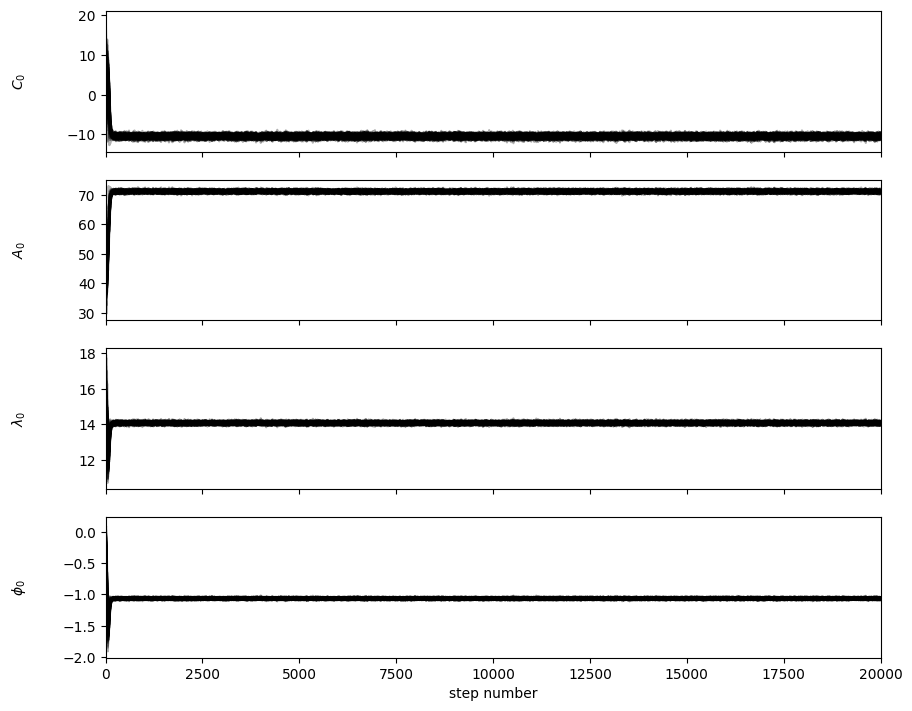

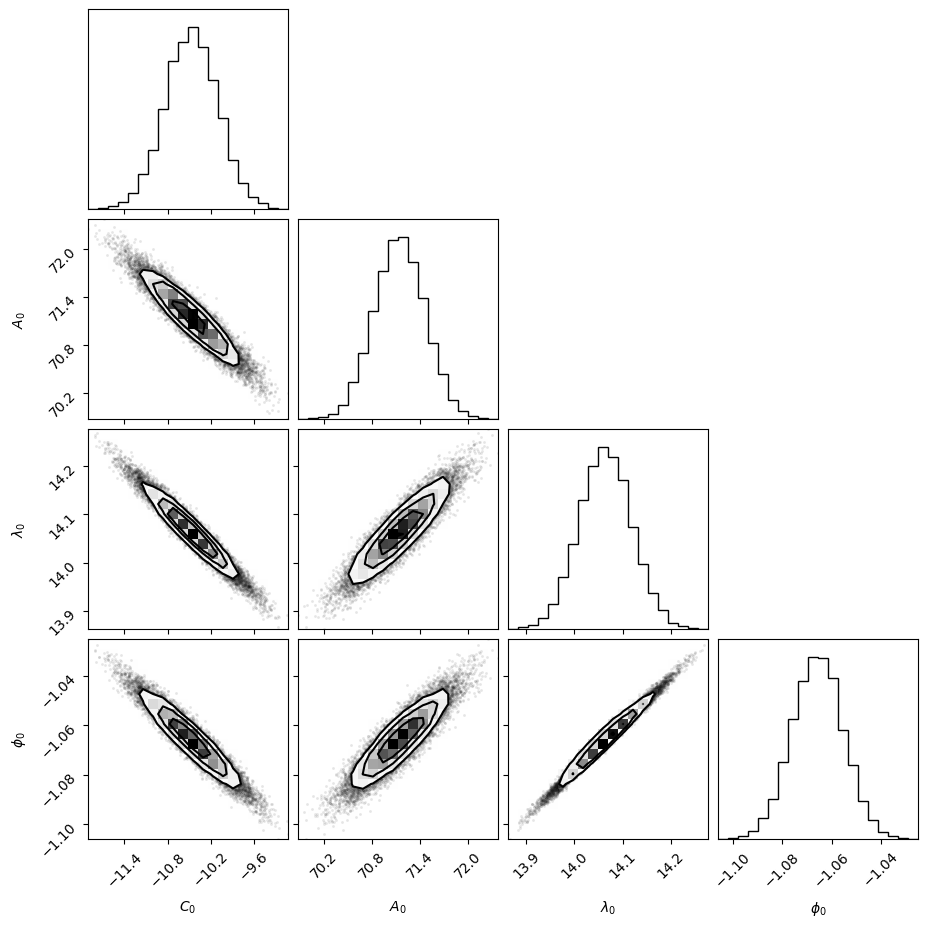

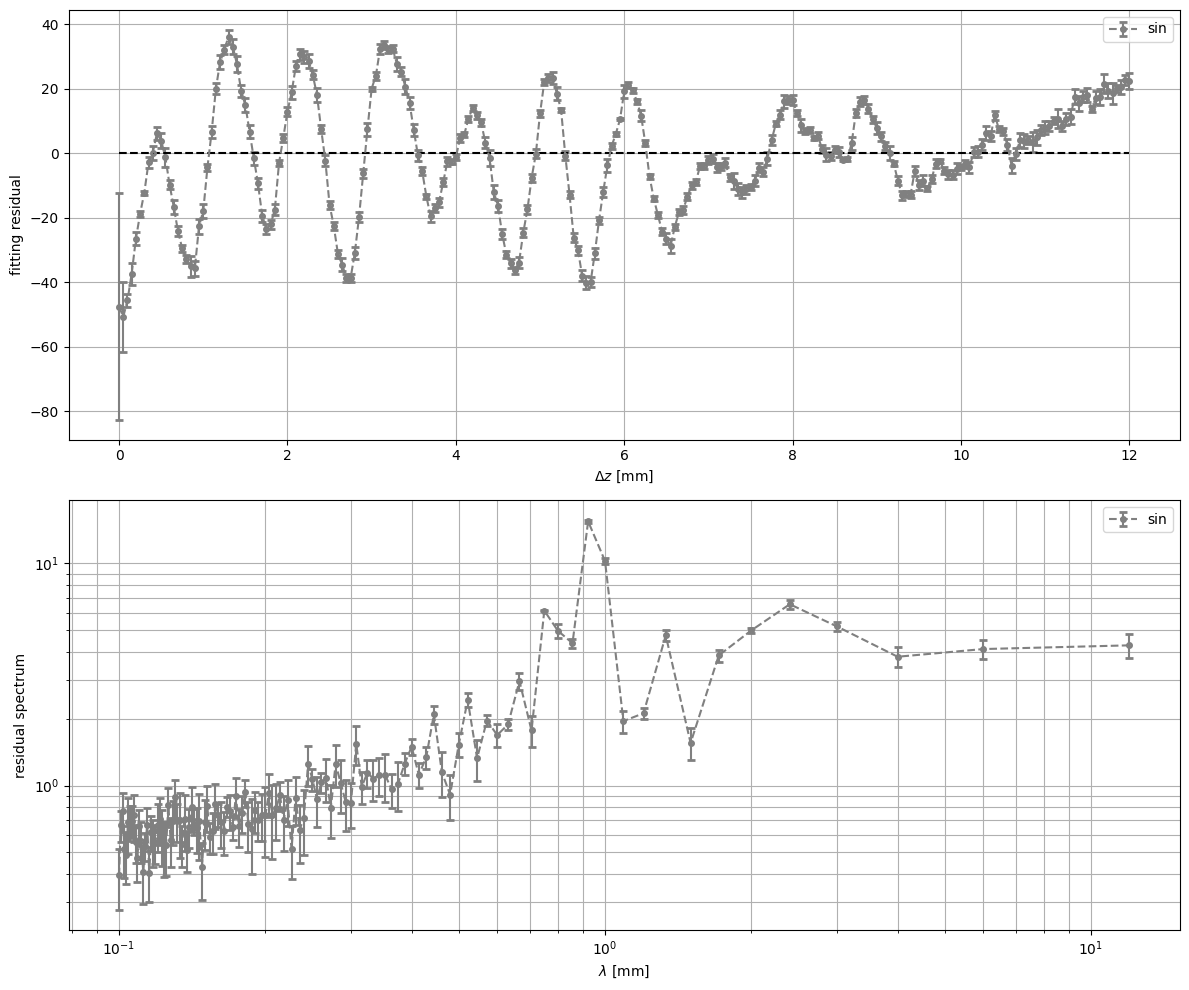

In [97]:
_ = Model_sin.plot_chain()

_ = Model_sin.plot_corner(
    discard=2*int(corr_time.max()),
    thin=int(corr_time.max()//2),
)
_ = Model_sin.plot_residual()

In [134]:
# 3. ran mcmc
# 3.2. sine model +1sw
n_walkers = 50

"""Model 1 3rd polynomial model"""
bounds_0 = np.asarray(
    [
        [-12,-8],
        [70, 72],
        [13.9, 14.5],
        [-1.5,-0.5],
        [10, 20],
        [0.9, 0.95],
        [-np.pi,0],
        
    ]
)
Model_sin_1sw = MCMC_Model(
    z_vec, data_samples1, 
    'sin', 2, 
    bounds_0,
    "sin + 1sw"
)

corr_time = Model_sin_1sw.sample(
    np.array([-10.8,
              71.2,
              14,
              -1,
              15,
              0.9,
              -1
              ]),
    n_walkers,
    20000,
    filename=outputfolder+'Sine_1sw_mcmc_analy.h5'
)

100%|██████████| 20000/20000 [03:38<00:00, 91.35it/s]


(6750, 7)


e:\E_Laptop_new\Project in Köln\1_Holography inference\CCAT-Documents\HOLO-Ref Rx\optics for CHAI\Fore-optics_Test\champ_optics_Model.py:271: RuntimeWarning: divide by zero encountered in divide
  1./freq,


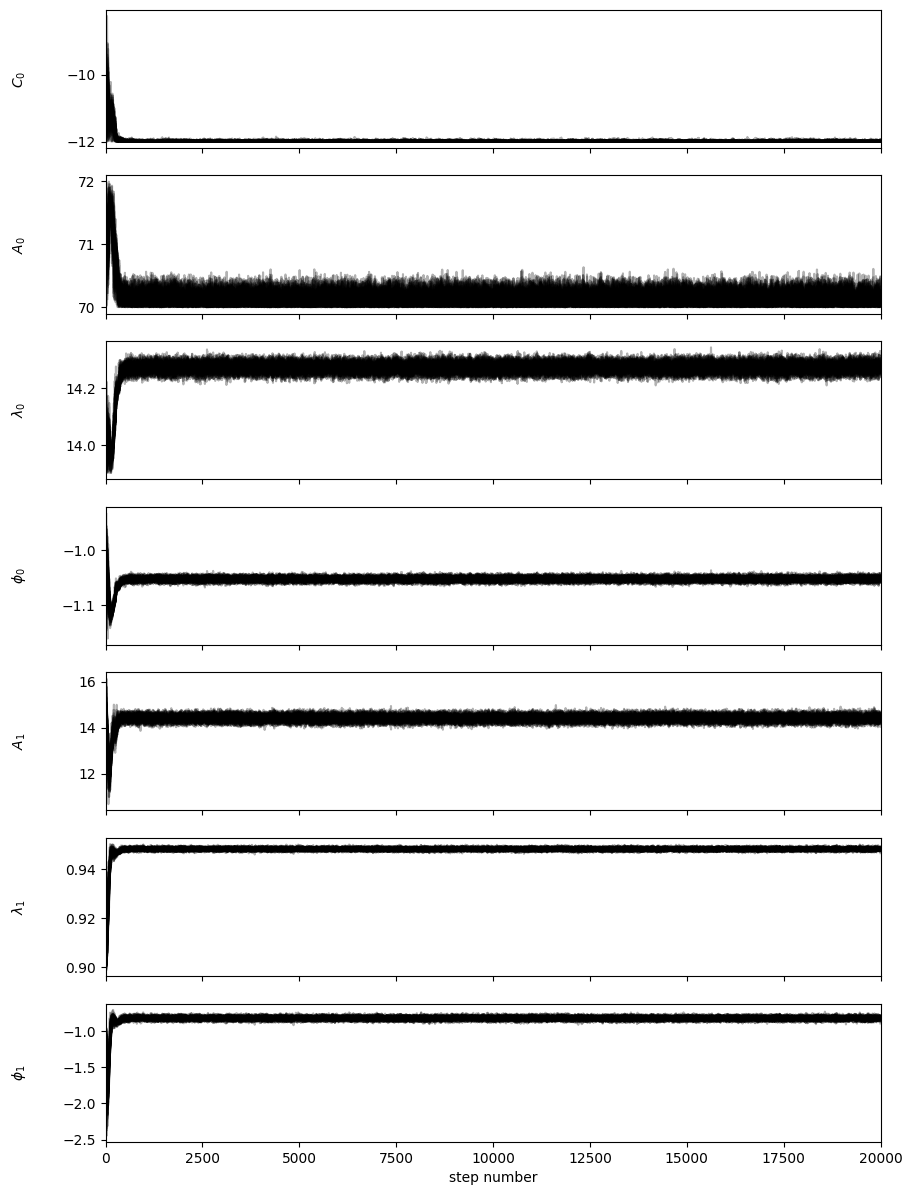

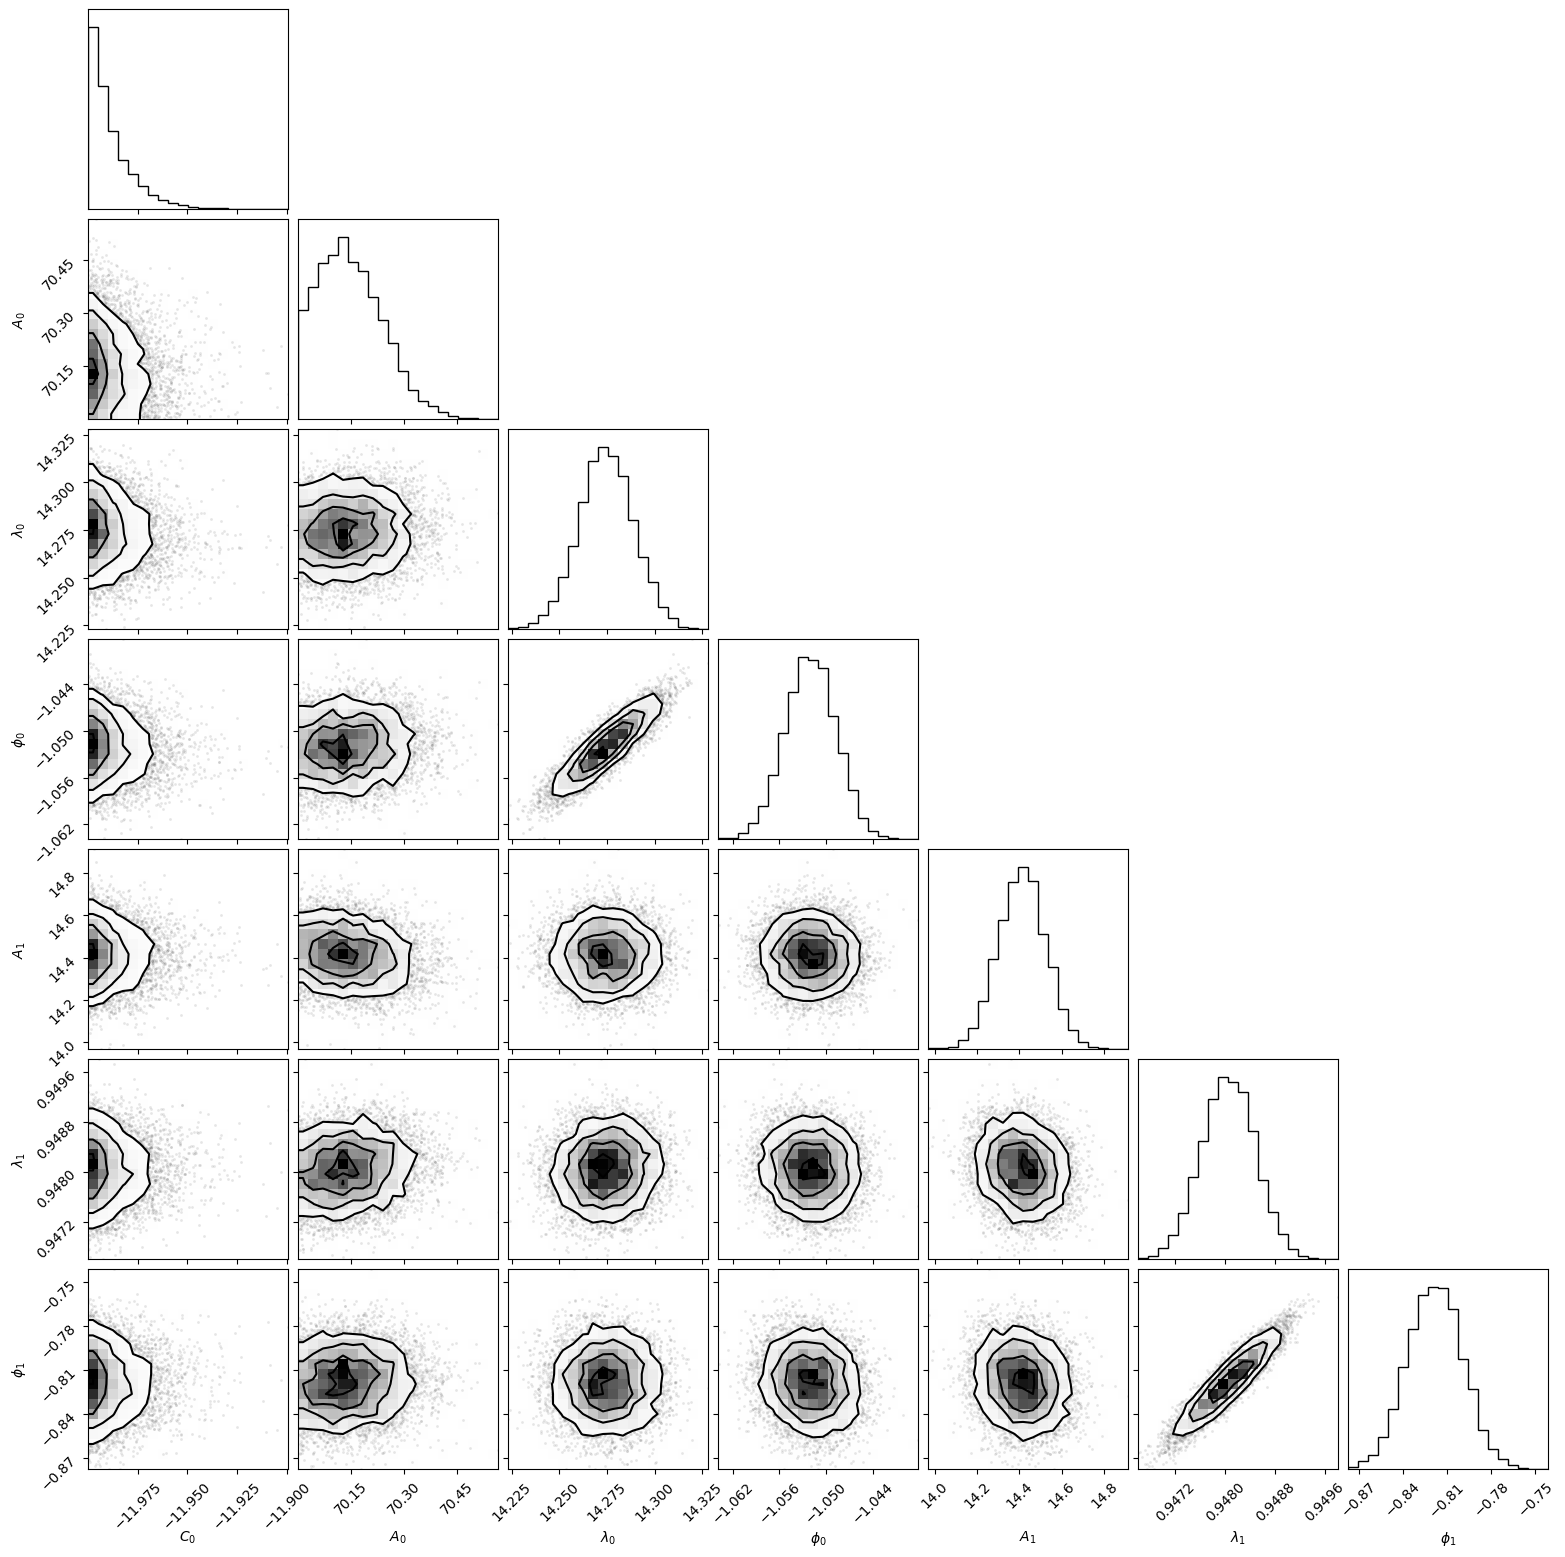

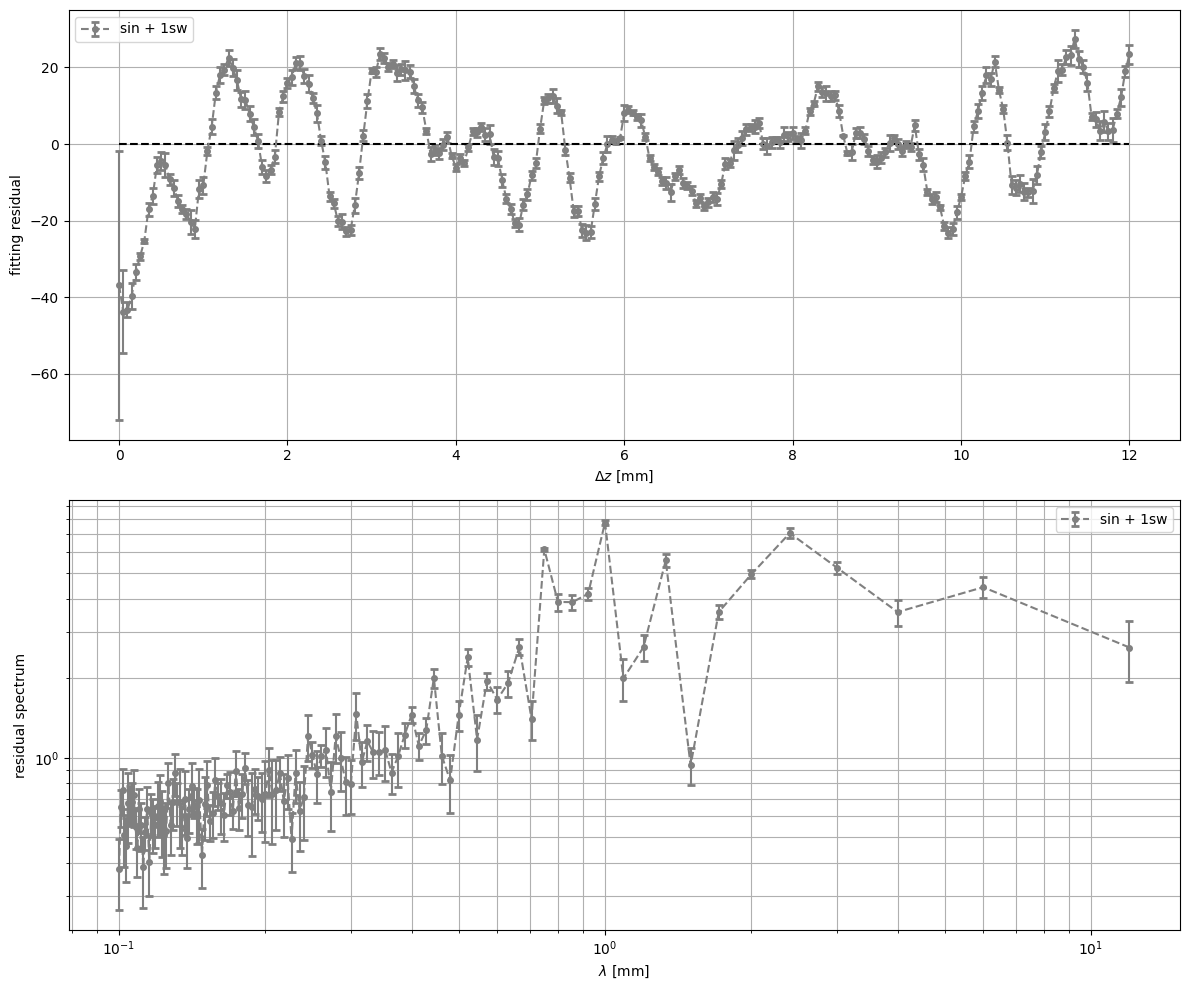

In [137]:
_ = Model_sin_1sw.plot_chain()

_ = Model_sin_1sw.plot_corner(
    discard=2*int(corr_time.max()),
    thin=int(corr_time.max()//2),

)
_ = Model_sin_1sw.plot_residual()

In [11]:
# 3. ran mcmc
# 3.2. sine model +1sw
n_walkers = 50

"""Model sin + 2sw model"""
bounds_0 = np.asarray(
    [
        [-12,-8],
        [70, 72],
        [13.9, 14.5],
        [-1.5,-0.5],
        [10, 20],
        [0.9, 0.95],
        [-np.pi,0],
        [6,9],
        [0.95,1.02],
        [-np.pi,np.pi]
        
    ]
)
Model_sin_2sw = MCMC_Model(
    z_vec, data_samples1, 
    'sin', 3, 
    bounds_0,
    "sin + 2sw"
)

corr_time = Model_sin_2sw.sample(
    np.array([-10.8,
              71.2,
              14,
              -1,
              15,
              0.9,
              -1,
              7,
              1.0,
              1
              ]),
    n_walkers,
    40000,
    filename=outputfolder+'Sine_2sw_mcmc_analy.h5'
)

  0%|          | 0/40000 [00:00<?, ?it/s]c:\Users\xiaod\.conda\envs\CCATholo\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 40000/40000 [06:55<00:00, 96.20it/s] 


(8450, 10)


e:\E_Laptop_new\Project in Köln\1_Holography inference\CCAT-Documents\HOLO-Ref Rx\optics for CHAI\Fore-optics_Test\champ_optics_Model.py:271: RuntimeWarning: divide by zero encountered in divide
  1./freq,


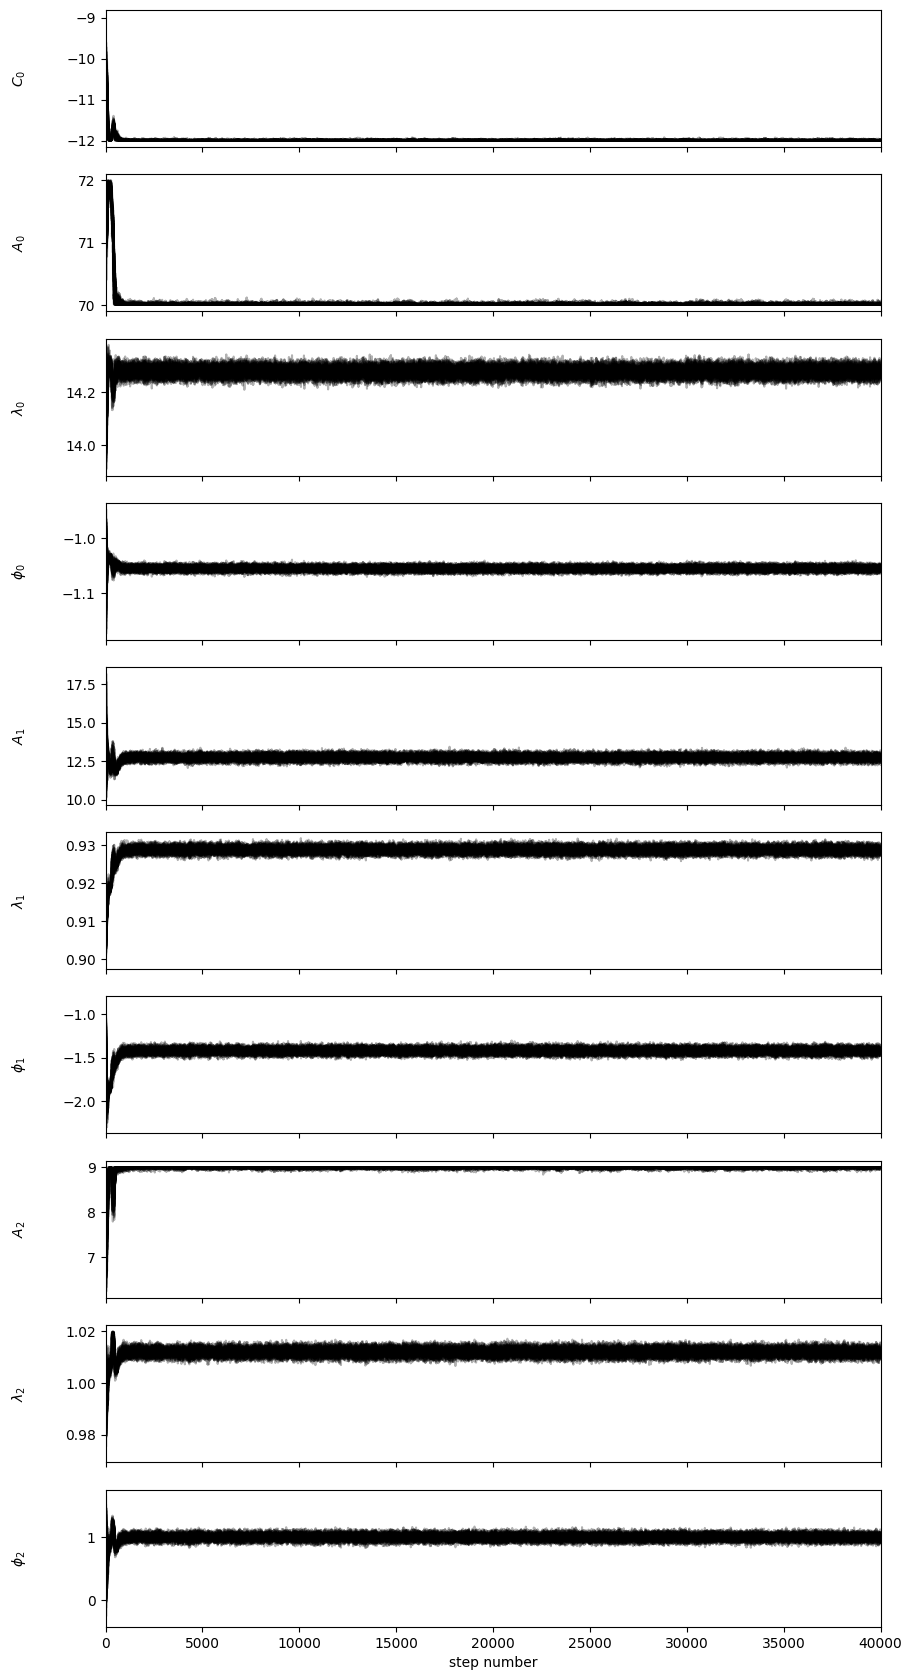

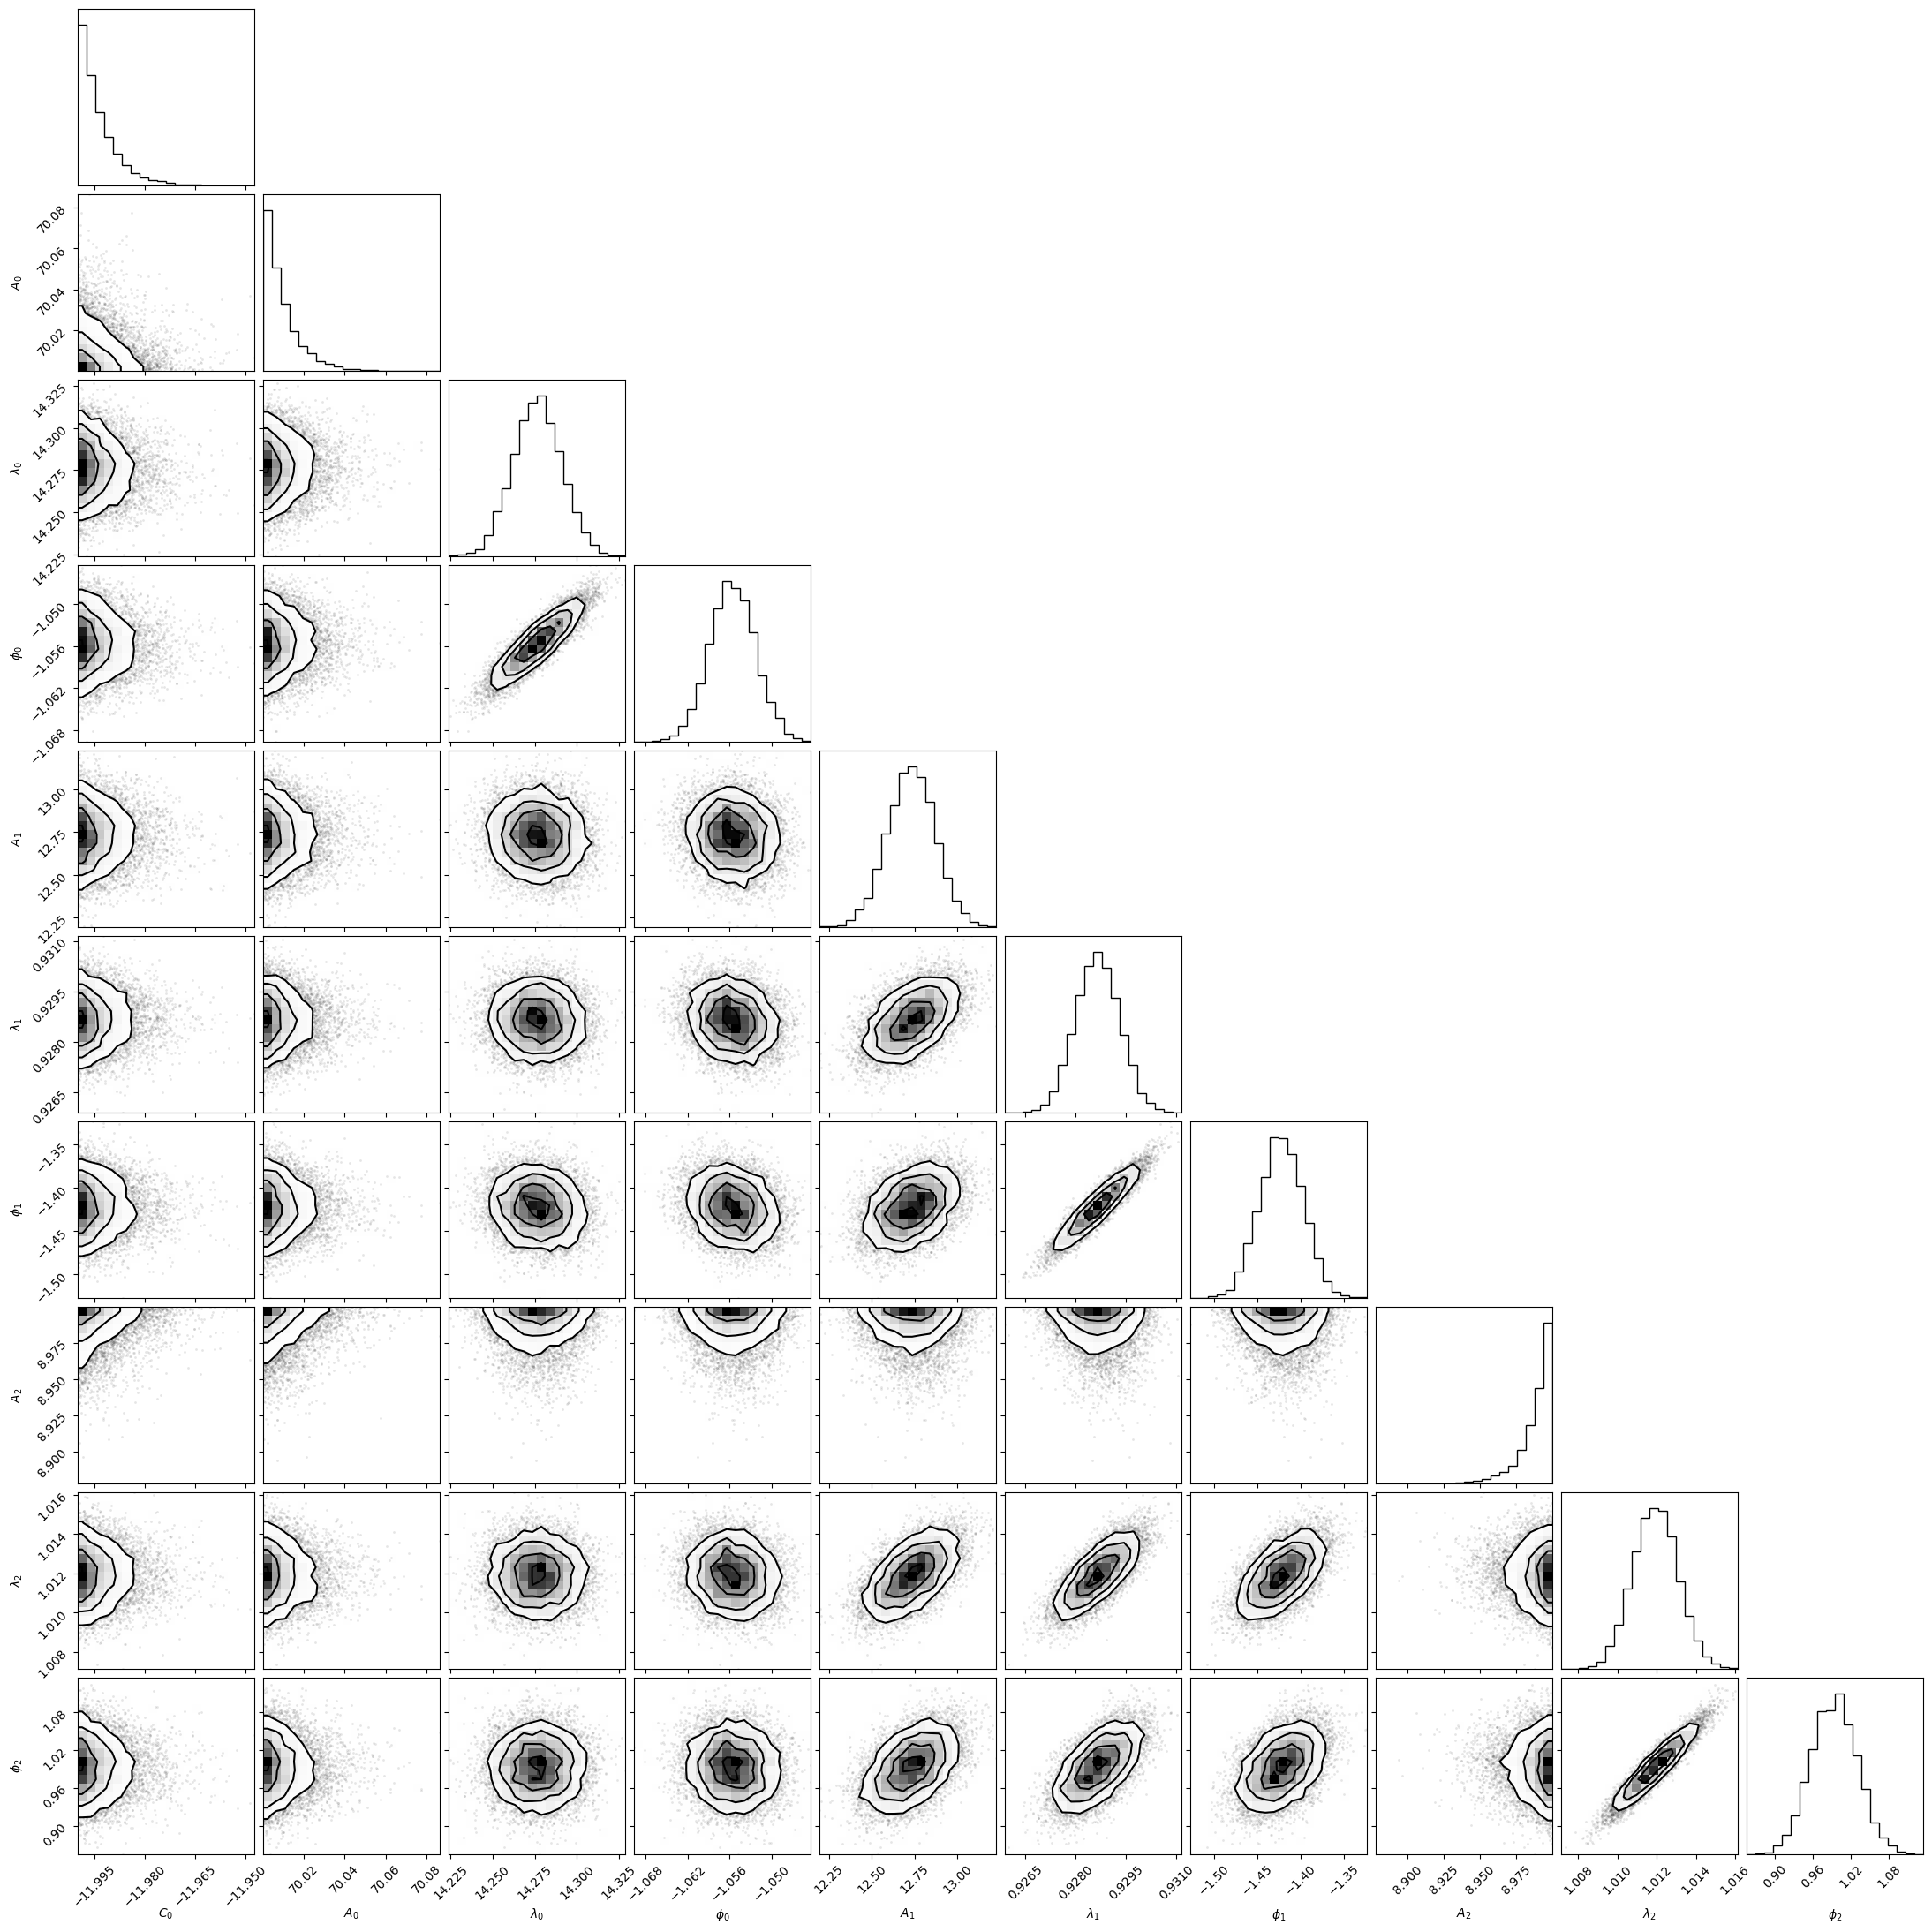

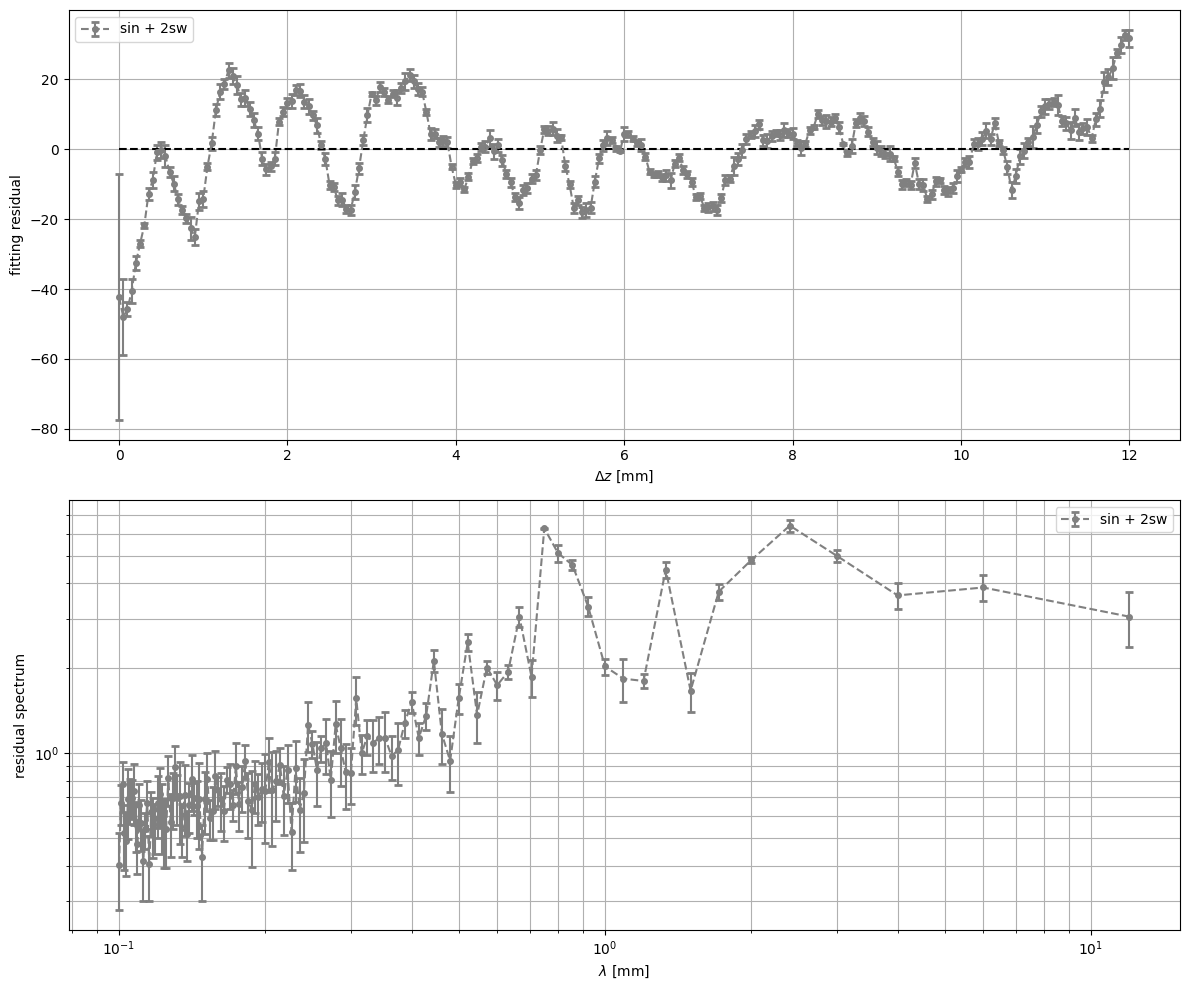

In [12]:
_ = Model_sin_2sw.plot_chain()

_ = Model_sin_2sw.plot_corner(
    discard=2*int(corr_time.max()),
    thin=int(corr_time.max()//2),

)
_ = Model_sin_2sw.plot_residual()